In [21]:
import gc
import sys
from statistics import mean
import time
import torch
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import itertools
from pathlib import Path
from scipy import special
import matplotlib.pyplot as plt
import datetime
import torch.linalg as LA
from torch.distributions.laplace import Laplace



import utils
import models
import learning_utils
from configurations import args_parser, arguments



In [22]:
%load_ext autoreload
%autoreload 2


start_time = time.time()
args = arguments()
#boardio is for the the tensorboardx prensetaion and textio is for written documentation
boardio, textio, best_val_acc, path_best_model, last_model_path = utils.initializations(args)
textio.cprint(str(args) if args.__class__.__name__ == 'Namespace' else str(vars(args)))

#mnist_train_data, mnist_test_loader  = utils.data(args)





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'exp_name': None, 'eval': False, 'data': 'mnist', 'norm_std': 0.5, 'norm_mean': 0.5, 'train_batch_size': 20, 'test_batch_size': 1000, 'model': 'cnn2', 'num_users': 30, 'num_users_per_round': 5, 'local_epochs': 1, 'local_iterations': 100, 'global_epochs': 200, 'tau_min': 0.05, 'privacy_noise': 'laplace', 'epsilon_bar': 400, 'optimizer': 'Adam', 'lr': 0.01, 'momentum': 0.5, 'lr_scheduler': False, 'device': device(type='cpu'), 'seed': 0, 'zeta_coeff': 1.05, 'alpha': 10, 'beta': 2, 'gamma': 1, 'max_seconds': 300, 'method_choosing_users': 'ALSA', 'data_truncation': 1750, 'choosing_users_verbose': True, 'save_best_model': False, 'privacy': True, 'privacy_choosing_users': True, 'epsilon_sum_deascent_coeff': 0.02, 'delta_f': 0.0008, 'snr_verbose': True, 'max_iterations_alsa': 500, 'ALSA_simulation': False, 'ALSA_verbose': False, 'beta_max_reduction': 20}


In [23]:
# data
train_data, test_loader = utils.data(args)
#input in the CNNs is the number of channels and in linear models is the size of the flatten pictures
input, output, train_data, val_loader = utils.data_split(train_data, len(test_loader.dataset), args)

# model
if args.model == 'mlp':
    global_model = models.FC2Layer(input, output)
elif args.model == 'cnn2':
    global_model = models.CNN2Layer(input, output, args.data)
elif args.model == 'cnn3':
    if args.data == 'cifar10':
        global_model = models.CNN3LayerCifar()
    else:
        global_model = models.CNN3LayerMnist()
elif args.model == 'cnn5':
    if args.data == 'mnist' or args.data == 'fashion mnist':
        raise ValueError('CNN5 is not supported for MNIST type datasets')
    global_model = models.CNN5Layer(input, output)
elif args.model == 'linear':
    global_model = models.Linear(input, output)



textio.cprint(str(summary(global_model)).encode('utf-8', errors='ignore').decode('utf-8', errors='ignore'))
global_model = global_model.to(args.device)
print(f"global model's device: {next(global_model.parameters()).device}")

train_criterion = torch.nn.CrossEntropyLoss(reduction='mean')
test_criterion = torch.nn.CrossEntropyLoss(reduction='sum')

local_models = utils.federated_setup(global_model, train_data, args, i_i_d=True)
utils.update_data_equility_partititon(local_models, args)





Layer (type:depth-idx)                   Param #
CNN2Layer                                --
├─Conv2d: 1-1                            156
├─Conv2d: 1-2                            906
├─Linear: 1-3                            4,850
├─Linear: 1-4                            510
├─Dropout: 1-5                           --
├─Dropout: 1-6                           --
├─BatchNorm2d: 1-7                       12
├─BatchNorm1d: 1-8                       100
Total params: 6,534
Trainable params: 6,534
Non-trainable params: 0
global model's device: cpu


In [24]:
# for i in range(100):
#     local_models[0].update_privacy_violation_and_reward()
#     print(f"iteration {i}, next_privacy_term is {local_models[0].next_privacy_term}")

  4%|▎         | 7/200 [00:00<00:11, 16.36it/s]

iteration: 1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
user 6, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.13849360544433548
user 22, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.8011717532223018
user 24, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.8300878615351364
user 17, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.7207796891795588
user 27, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.8872186616668128
max_delay = 0.89 seconds
iteration: 2
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 25, 26, 28, 29]
user 21, g: 0.027777777777777776, ucb: inf, num_of_obs: 1, privacy reward: 0.9801986733067553, curr_delay = 0.8

  4%|▍         | 9/200 [00:01<00:36,  5.26it/s]

user 12, g: 0.0030864197530864196, ucb: 8.427428614694987, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.20097624284468188
user 13, g: 0.0030864197530864196, ucb: 8.389695211559236, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.1565390614520586
user 14, g: 0.0030864197530864196, ucb: 8.35303463157268, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.21964056743421995
user 16, g: 0.0030864197530864196, ucb: 8.188404271572004, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7206545290753982
user 9, g: 0.0030864197530864196, ucb: 8.430739369476925, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.16139960573235007
max_delay = 0.72 seconds
iteration: 10


  6%|▌         | 11/200 [00:02<01:01,  3.06it/s]

user 11, g: 0.004444444444444443, ucb: 8.59827708723615, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.16858164094889405
user 15, g: 0.004444444444444443, ucb: 8.382261715057952, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7149518626565735
user 17, g: 0.004444444444444443, ucb: 8.380660005635075, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7366449962990969
user 18, g: 0.004444444444444443, ucb: 8.377872702935734, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7552363331015601
user 20, g: 0.004444444444444443, ucb: 8.37646029914658, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7792718236517056
max_delay = 0.78 seconds
iteration: 11
user 19, g: 0.005739210284664828, ucb: 8.546717394046492, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.770759972870536
user 22, g: 0.005739210284664828, ucb: 8.543968481626557, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_del

  6%|▌         | 12/200 [00:03<01:13,  2.55it/s]

user 21, g: 0.006944444444444444, ucb: 8.694749219481404, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.7723220774940904
user 26, g: 0.006944444444444444, ucb: 8.691233029942259, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.8608808158185132
user 27, g: 0.006944444444444444, ucb: 8.690427904185162, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.8557444684179888
user 28, g: 0.006944444444444444, ucb: 8.689554916895217, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.8733936301706746
user 29, g: 0.006944444444444444, ucb: 8.686942451714753, num_of_obs: 2, privacy reward: 0.9607894391523231, curr_delay = 0.907615255875308
max_delay = 0.91 seconds
iteration: 13


  7%|▋         | 14/200 [00:04<01:15,  2.47it/s]

user 0, g: 0.00016436554898093314, ucb: 6.917904034408428, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.05590805601010199
user 1, g: 0.00016436554898093314, ucb: 6.813457054574498, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.09283965870278651
user 2, g: 0.00016436554898093314, ucb: 6.9120731032677964, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.07374084594248
user 3, g: 0.00016436554898093314, ucb: 6.7880594249151995, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.0811516106929895
user 4, g: 0.00016436554898093314, ucb: 6.700362226866966, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.10516406459064248
max_delay = 0.11 seconds
iteration: 14
user 10, g: 0.0005668934240362811, ucb: 6.634212289229031, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.15714548867945566
user 5, g: 0.0005668934240362811, ucb: 6.755774140275013, num_of_obs: 3, privacy reward: 0.94176453358424

  8%|▊         | 15/200 [00:04<01:19,  2.32it/s]

user 12, g: 0.0011111111111111107, ucb: 6.652092180019069, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.18524916036100098
user 13, g: 0.0011111111111111107, ucb: 6.668537214072538, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.20376303994407172
user 15, g: 0.0011111111111111107, ucb: 6.443894128489035, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.6943142861795093
user 17, g: 0.0011111111111111107, ucb: 6.442063534555014, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7710910584273055
user 9, g: 0.0011111111111111107, ucb: 6.684249795374105, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.14440603232083382
max_delay = 0.77 seconds
iteration: 16


  8%|▊         | 16/200 [00:05<01:25,  2.14it/s]

user 11, g: 0.0017361111111111104, ucb: 6.7407295912753975, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.18995997594295688
user 14, g: 0.0017361111111111104, ucb: 6.679823766349161, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.19599595490908603
user 16, g: 0.0017361111111111104, ucb: 6.51837694759912, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7129128886105898
user 20, g: 0.0017361111111111104, ucb: 6.513606328331875, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7567230407313238
user 21, g: 0.0017361111111111104, ucb: 6.511648806810605, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7797847255884157
max_delay = 0.78 seconds
iteration: 17


  8%|▊         | 17/200 [00:05<01:35,  1.92it/s]

user 19, g: 0.002402921953094963, ucb: 6.58407863325373, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7466697748896686
user 22, g: 0.002402921953094963, ucb: 6.581165790731273, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7971948797744235
user 23, g: 0.002402921953094963, ucb: 6.579421202251087, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8270148631559614
user 24, g: 0.002402921953094963, ucb: 6.578476003984079, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8404966052774716
user 25, g: 0.002402921953094963, ucb: 6.578323158631402, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8606704196146271
max_delay = 0.86 seconds
iteration: 18


 10%|▉         | 19/200 [00:06<01:31,  1.97it/s]

user 18, g: 0.0030864197530864196, ucb: 6.650888380881738, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.7414245985626411
user 26, g: 0.0030864197530864196, ucb: 6.642115683012366, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.846315351905924
user 27, g: 0.0030864197530864196, ucb: 6.6418874240994965, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8490549718944367
user 28, g: 0.0030864197530864196, ucb: 6.640860579905671, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.8840104427623957
user 29, g: 0.0030864197530864196, ucb: 6.638475080464442, num_of_obs: 3, privacy reward: 0.9417645335842486, curr_delay = 0.90853160130567
max_delay = 0.91 seconds
iteration: 19
user 0, g: 7.694675284702985e-05, ucb: 6.201139214914373, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.06561187692791678
user 1, g: 7.694675284702985e-05, ucb: 6.012920377544305, num_of_obs: 4, privacy reward: 0.9231163463866355, cu

 10%|█         | 21/200 [00:07<01:25,  2.08it/s]

iteration: 21
user 11, g: 0.0005668934240362811, ucb: 5.799983111044707, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.18790971978311238
user 12, g: 0.0005668934240362811, ucb: 5.793455351978931, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.19452519058717788
user 15, g: 0.0005668934240362811, ucb: 5.588692231269755, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.7063127669607943
user 16, g: 0.0005668934240362811, ucb: 5.587388500123594, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.7213448186873828
user 17, g: 0.0005668934240362811, ucb: 5.585081731134512, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.7375949297659169
max_delay = 0.74 seconds


 11%|█         | 22/200 [00:08<01:31,  1.94it/s]

iteration: 22
user 13, g: 0.0009182736455463729, ucb: 5.838239446380423, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.1996575635723306
user 14, g: 0.0009182736455463729, ucb: 5.798672516868695, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.1974541417936227
user 19, g: 0.0009182736455463729, ucb: 5.6253786120414615, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.7528298488683239
user 20, g: 0.0009182736455463729, ucb: 5.624849913732933, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.764234752290895
user 9, g: 0.0009182736455463729, ucb: 5.882335452183169, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.14551638996192504
max_delay = 0.76 seconds
iteration: 23


 12%|█▏        | 23/200 [00:08<01:37,  1.82it/s]

user 18, g: 0.0013127494223902538, ucb: 5.666289790372716, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.7630456003959171
user 21, g: 0.0013127494223902538, ucb: 5.662727488592392, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.7718529783967119
user 22, g: 0.0013127494223902538, ucb: 5.66185598148729, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8134969932842252
user 23, g: 0.0013127494223902538, ucb: 5.659939083970429, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8242054970731708
user 24, g: 0.0013127494223902538, ucb: 5.65898569661697, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8125920129787036
max_delay = 0.82 seconds
iteration: 24


 12%|█▏        | 24/200 [00:09<01:42,  1.73it/s]

user 25, g: 0.0017361111111111104, ucb: 5.696293632928966, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.837861403973386
user 26, g: 0.0017361111111111104, ucb: 5.695529919862841, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.875698505995911
user 27, g: 0.0017361111111111104, ucb: 5.695314203766672, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8685377304011594
user 28, g: 0.0017361111111111104, ucb: 5.6938534462198245, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.8599780081386346
user 29, g: 0.0017361111111111104, ucb: 5.691754260303075, num_of_obs: 4, privacy reward: 0.9231163463866355, curr_delay = 0.9244256939712346
max_delay = 0.92 seconds
iteration: 25


 12%|█▎        | 25/200 [00:10<01:31,  1.91it/s]

user 0, g: 4.444444444444428e-05, ucb: 5.685074361338201, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.05897238416544495
user 1, g: 4.444444444444428e-05, ucb: 5.599816280575838, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.0671444560760338
user 2, g: 4.444444444444428e-05, ucb: 5.595135439263029, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.05361132993493174
user 3, g: 4.444444444444428e-05, ucb: 5.503117092894344, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.08551993568695096
user 5, g: 4.444444444444428e-05, ucb: 5.420725659849276, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.07117380208245246
max_delay = 0.09 seconds
iteration: 26


 14%|█▎        | 27/200 [00:10<01:23,  2.08it/s]

user 10, g: 0.00016436554898093314, ucb: 5.266494047708782, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.18204106432822037
user 11, g: 0.00016436554898093314, ucb: 5.221469644577583, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.13673039503383252
user 4, g: 0.00016436554898093314, ucb: 5.409597483344747, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.11422581111120167
user 7, g: 0.00016436554898093314, ucb: 5.301615452318468, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.1354258830905336
user 8, g: 0.00016436554898093314, ucb: 5.300578204843605, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.13184280758668573
max_delay = 0.18 seconds
iteration: 27
user 0, g: -0.0003429355281207133, ucb: 5.23381617921004, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.08487272236246385
user 12, g: 0.0003429355281207133, ucb: 5.242859312440294, num_of_obs: 5, privacy reward: 0.90483741803

 14%|█▍        | 28/200 [00:11<01:26,  2.00it/s]

iteration: 28
user 14, g: 0.0005668934240362811, ucb: 5.241677715181522, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.21660682472775727
user 15, g: 0.0005668934240362811, ucb: 5.070080680477864, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.7141678595375963
user 16, g: 0.0005668934240362811, ucb: 5.068734084335409, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.7472153595595781
user 17, g: 0.0005668934240362811, ucb: 5.066622234332593, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.7150267287420573
user 20, g: 0.0005668934240362811, ucb: 5.064361155196206, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8049856071004542
max_delay = 0.80 seconds
iteration: 29


 14%|█▍        | 29/200 [00:12<01:30,  1.88it/s]

user 18, g: 0.0008257365570088515, ucb: 5.091845091251636, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.7501524053690255
user 19, g: 0.0008257365570088515, ucb: 5.091259473998581, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.7933715990807874
user 21, g: 0.0008257365570088515, ucb: 5.088986438116057, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8268114612315677
user 22, g: 0.0008257365570088515, ucb: 5.087503774307208, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.806550837277729
user 23, g: 0.0008257365570088515, ucb: 5.085866461267181, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8149342927595592
max_delay = 0.83 seconds
iteration: 30


 15%|█▌        | 30/200 [00:12<01:31,  1.86it/s]

user 24, g: 0.0011111111111111107, ucb: 5.1106024334261875, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8302888929590958
user 25, g: 0.0011111111111111107, ucb: 5.1097134743930255, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.842519654569621
user 26, g: 0.0011111111111111107, ucb: 5.108496073587232, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8777709569627464
user 27, g: 0.0011111111111111107, ucb: 5.108451973050763, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.8670190496510294
user 28, g: 0.0011111111111111107, ucb: 5.107499654567661, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.891701967819261
max_delay = 0.89 seconds
iteration: 31


 16%|█▌        | 31/200 [00:13<01:24,  2.00it/s]

user 1, g: 2.8905075731298364e-05, ucb: 5.237214482091654, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.06655122973417447
user 2, g: 2.8905075731298364e-05, ucb: 5.271064921556336, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.07654664113820005
user 29, g: 0.001416348710833622, ucb: 5.129199307637372, num_of_obs: 5, privacy reward: 0.9048374180359593, curr_delay = 0.903900959156424
user 3, g: 2.8905075731298364e-05, ucb: 5.127854308215778, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.09635282506209944
user 5, g: 2.8905075731298364e-05, ucb: 5.085510497317362, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.11951458276980596
max_delay = 0.90 seconds
iteration: 32
user 0, g: -0.0004340277777777782, ucb: 4.916713258230252, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.05
user 4, g: 0.00010850694444444425, ucb: 5.0207130019536805, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay

 16%|█▌        | 32/200 [00:13<01:17,  2.17it/s]

iteration: 33


 16%|█▋        | 33/200 [00:13<01:14,  2.24it/s]

user 1, g: -0.00022956841138659364, ucb: 4.888145983896113, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.09077776543819537
user 10, g: 0.0002295684113865928, ucb: 4.8938164043696055, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.159242456376549
user 11, g: 0.0002295684113865928, ucb: 4.876000848998601, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.19808372708040617
user 2, g: -0.00022956841138659364, ucb: 4.900003951284253, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.09106466693785709
user 9, g: 0.0002295684113865928, ucb: 4.907768357246523, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.1479104821878592
max_delay = 0.20 seconds
iteration: 34


 17%|█▋        | 34/200 [00:14<01:18,  2.13it/s]

user 12, g: 0.0003844675124951936, ucb: 4.8726871056840855, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.17006907675042057
user 13, g: 0.0003844675124951936, ucb: 4.866603121114399, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.16264961966703168
user 14, g: 0.0003844675124951936, ucb: 4.839986458269346, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.2012213775613908
user 3, g: -9.611687812379895e-05, ucb: 4.776094904562477, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.08940555413651412
user 5, g: -9.611687812379895e-05, ucb: 4.724047202908163, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.11451593537661481
max_delay = 0.20 seconds
iteration: 35


 18%|█▊        | 35/200 [00:14<01:23,  1.98it/s]

user 16, g: 0.0005668934240362811, ucb: 4.68771502145624, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7304256549011028
user 17, g: 0.0005668934240362811, ucb: 4.686628010081354, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.767513623960451
user 18, g: 0.0005668934240362811, ucb: 4.685148222215772, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7481621461956034
user 20, g: 0.0005668934240362811, ucb: 4.683256237960331, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7924716332102663
user 21, g: 0.0005668934240362811, ucb: 4.681625331009854, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.801514561068243
max_delay = 0.80 seconds
iteration: 36


 18%|█▊        | 36/200 [00:15<01:31,  1.80it/s]

user 15, g: 0.000771604938271604, ucb: 4.707673538045554, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7259143107397092
user 19, g: 0.000771604938271604, ucb: 4.702215489893273, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7605634524450878
user 22, g: 0.000771604938271604, ucb: 4.699004970601059, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.7918738097980741
user 23, g: 0.000771604938271604, ucb: 4.697567573617062, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8279932885628465
user 25, g: 0.000771604938271604, ucb: 4.696056007472666, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8612642699304953
max_delay = 0.86 seconds
iteration: 37


 18%|█▊        | 37/200 [00:16<01:50,  1.47it/s]

user 24, g: 0.000994237480723966, ucb: 4.714634846522887, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8288076739246983
user 26, g: 0.000994237480723966, ucb: 4.712298251550578, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8503473830721261
user 27, g: 0.000994237480723966, ucb: 4.712404249487974, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8848162624414715
user 28, g: 0.000994237480723966, ucb: 4.711323132033438, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.8601345099184518
user 29, g: 0.000994237480723966, ucb: 4.709101592932341, num_of_obs: 6, privacy reward: 0.8869204367171573, curr_delay = 0.9108007462489297
max_delay = 0.91 seconds
iteration: 38


 19%|█▉        | 38/200 [00:17<01:40,  1.61it/s]

user 2, g: -0.0003077870113881194, ucb: 4.64291788316354, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.07265578908174308
user 4, g: 7.694675284702985e-05, ucb: 4.732258785959395, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.11669487887182692
user 6, g: 7.694675284702985e-05, ucb: 4.671030332413549, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.12216991741825031
user 7, g: 7.694675284702985e-05, ucb: 4.625750122189381, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.1308487965335962
user 8, g: 7.694675284702985e-05, ucb: 4.626894032509605, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.0917690870781829
max_delay = 0.13 seconds
iteration: 39


 20%|█▉        | 39/200 [00:17<01:35,  1.69it/s]

user 0, g: -0.00016436554898093385, ucb: 4.751537624868868, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.05884506593099896
user 1, g: -0.00016436554898093385, ucb: 4.647074121162769, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.07897945041030235
user 10, g: 0.00016436554898093314, ucb: 4.59353498496826, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.18714274591507285
user 11, g: 0.00016436554898093314, ucb: 4.568427338462365, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.166419456431913
user 9, g: 0.00016436554898093314, ucb: 4.609170893492346, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.11366042301352029
max_delay = 0.19 seconds
iteration: 40


 20%|██        | 40/200 [00:18<01:30,  1.77it/s]

user 0, g: -0.0011111111111111124, ucb: 4.51598044349594, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.07733096309470472
user 12, g: 0.00027777777777777767, ucb: 4.571099420972796, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.17232073125048533
user 13, g: 0.00027777777777777767, ucb: 4.568264613687635, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.19298719198543146
user 14, g: 0.00027777777777777767, ucb: 4.536262941347952, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.19848364976615343
user 3, g: -6.944444444444442e-05, ucb: 4.5506390689849345, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.09202010689906664
max_delay = 0.20 seconds
iteration: 41


 20%|██        | 41/200 [00:18<01:46,  1.49it/s]

user 15, g: 0.0004131138872364333, ucb: 4.379477296684176, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.6927680500135076
user 16, g: 0.0004131138872364333, ucb: 4.377992589969551, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.7269424102658367
user 18, g: 0.0004131138872364333, ucb: 4.37558312333436, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.7636610340801996
user 19, g: 0.0004131138872364333, ucb: 4.374405936788786, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.7740311755071123
user 21, g: 0.0004131138872364333, ucb: 4.371905958288262, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.7948298400111565
max_delay = 0.79 seconds
iteration: 42


 21%|██        | 42/200 [00:20<02:06,  1.25it/s]

user 17, g: 0.0005668934240362811, ucb: 4.390493636921102, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.742021734580396
user 20, g: 0.0005668934240362811, ucb: 4.3873418797583135, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.7680807309574239
user 22, g: 0.0005668934240362811, ucb: 4.3852554691375945, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.7946139216493388
user 24, g: 0.0005668934240362811, ucb: 4.383067382577623, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.8330880284721813
user 25, g: 0.0005668934240362811, ucb: 4.381950136028859, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.8613926072183127
max_delay = 0.86 seconds
iteration: 43


 22%|██▏       | 43/200 [00:21<02:18,  1.14it/s]

user 23, g: 0.000736133645814554, ucb: 4.397184949403808, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.8277805973002701
user 26, g: 0.000736133645814554, ucb: 4.394451911644028, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.877074531570147
user 27, g: 0.000736133645814554, ucb: 4.394158477966308, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.8589616890430763
user 28, g: 0.000736133645814554, ucb: 4.393527802713197, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.915159994325828
user 29, g: 0.000736133645814554, ucb: 4.391137571156629, num_of_obs: 7, privacy reward: 0.8693582353988054, curr_delay = 0.9192570085415208
max_delay = 0.92 seconds
iteration: 44


 22%|██▏       | 44/200 [00:21<02:07,  1.22it/s]

user 1, g: -0.00022956841138659364, ucb: 4.445240123925538, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.0863576633361045
user 2, g: -0.00022956841138659364, ucb: 4.460804229989822, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.08177732492835384
user 4, g: 5.73921028466482e-05, ucb: 4.489100051493852, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.0829965205324994
user 5, g: 5.73921028466482e-05, ucb: 4.539546522843077, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.1011174141499729
user 6, g: 5.73921028466482e-05, ucb: 4.433875410867067, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.14327975739351362
max_delay = 0.14 seconds
iteration: 45


 22%|██▎       | 45/200 [00:22<02:02,  1.27it/s]

user 10, g: 0.00012345679012345652, ucb: 4.346063940082388, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.17088508417277964
user 3, g: -0.00012345679012345715, ucb: 4.348854306721406, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.0630026431398128
user 7, g: 0.00012345679012345652, ucb: 4.403126015926131, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.15355710558233804
user 8, g: 0.00012345679012345652, ucb: 4.4273529875731805, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.13335766018816844
user 9, g: 0.00012345679012345652, ucb: 4.384142023174024, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.14460972763091642
max_delay = 0.17 seconds
iteration: 46


 23%|██▎       | 46/200 [00:23<01:52,  1.36it/s]

user 11, g: 0.0002100399075824401, ucb: 4.340939616741568, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.134882817617336
user 12, g: 0.0002100399075824401, ucb: 4.32910592737801, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.19858178511786326
user 13, g: 0.0002100399075824401, ucb: 4.322237226349387, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.2059800374520048
user 14, g: 0.0002100399075824401, ucb: 4.293782273949141, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.218709948704499
user 5, g: -5.250997689561023e-05, ucb: 4.299270969653561, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.1202204330741824
max_delay = 0.22 seconds
iteration: 47


 24%|██▎       | 47/200 [00:23<01:48,  1.41it/s]

user 15, g: 0.0003143705045017855, ucb: 4.132779054075445, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7087801539790626
user 16, g: 0.0003143705045017855, ucb: 4.131021735506179, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7362282430324643
user 17, g: 0.0003143705045017855, ucb: 4.129573072885109, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7254583511894518
user 18, g: 0.0003143705045017855, ucb: 4.128484026357115, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.72724385930457
user 19, g: 0.0003143705045017855, ucb: 4.127349695904795, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7780831697095302
max_delay = 0.78 seconds
iteration: 48


 24%|██▍       | 48/200 [00:24<01:42,  1.49it/s]

user 20, g: 0.000434027777777777, ucb: 4.13763602942084, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7922621615220996
user 21, g: 0.000434027777777777, ucb: 4.136056435866581, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.7698814919781958
user 22, g: 0.000434027777777777, ucb: 4.135537151149949, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8460373468171564
user 23, g: 0.000434027777777777, ucb: 4.133756785968214, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.812814045998429
user 24, g: 0.000434027777777777, ucb: 4.1332465094677735, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8469230572061874
max_delay = 0.85 seconds
iteration: 49


 24%|██▍       | 49/200 [00:24<01:38,  1.54it/s]

user 25, g: 0.0005668934240362811, ucb: 4.142840299617158, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8826399655583657
user 26, g: 0.0005668934240362811, ucb: 4.141762375820597, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8430338714429089
user 27, g: 0.0005668934240362811, ucb: 4.141682592074638, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8807604967162197
user 28, g: 0.0005668934240362811, ucb: 4.140631362079606, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8972828417080405
user 29, g: 0.0005668934240362811, ucb: 4.138547806096607, num_of_obs: 8, privacy reward: 0.8521437889662109, curr_delay = 0.8807538861004891
max_delay = 0.90 seconds
iteration: 50


 25%|██▌       | 50/200 [00:25<01:24,  1.77it/s]

user 0, g: -0.00017777777777777784, ucb: 4.391093709107566, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.06056891967561218
user 1, g: -0.00017777777777777784, ucb: 4.278266876058524, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.09514847863426801
user 2, g: -0.00017777777777777784, ucb: 4.295704861143384, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.09008572344762869
user 4, g: 4.444444444444428e-05, ucb: 4.309663514664081, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.08008625344111238
user 6, g: 4.444444444444428e-05, ucb: 4.229658548489175, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.09942597989594512
max_delay = 0.10 seconds
iteration: 51


 26%|██▌       | 51/200 [00:25<01:16,  1.94it/s]

user 10, g: 9.61168781237984e-05, ucb: 4.145011072108523, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.15977198931274106
user 3, g: -9.611687812379895e-05, ucb: 4.215638538938151, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.09236283263366957
user 7, g: 9.61168781237984e-05, ucb: 4.199067572611406, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.1054183377472693
user 8, g: 9.61168781237984e-05, ucb: 4.226431151471833, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.15550586788621196
user 9, g: 9.61168781237984e-05, ucb: 4.184974884225978, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.14592562605951728
max_delay = 0.16 seconds
iteration: 52


 26%|██▌       | 52/200 [00:26<01:12,  2.04it/s]

user 11, g: 0.00016436554898093314, ucb: 4.1495715187770275, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.15745476307974726
user 12, g: 0.00016436554898093314, ucb: 4.12435370202463, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.21796219187801028
user 13, g: 0.00016436554898093314, ucb: 4.117213156179268, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.16967773247479587
user 4, g: -4.109138724523346e-05, ucb: 4.124760955465971, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.13230600820494193
user 5, g: -4.109138724523346e-05, ucb: 4.12884327577956, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.09601323957596553
max_delay = 0.22 seconds
iteration: 53


 26%|██▋       | 53/200 [00:26<01:10,  2.08it/s]

user 14, g: 0.0002472212333372888, ucb: 4.09981622045386, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.19067765767168118
user 16, g: 0.0002472212333372888, ucb: 3.9273724770094214, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7499538488479899
user 17, g: 0.0002472212333372888, ucb: 3.9262309250293144, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7669038229840838
user 18, g: 0.0002472212333372888, ucb: 3.9252568574215165, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7397009755070143
user 19, g: 0.0002472212333372888, ucb: 3.9237027874734083, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7787977497120407
max_delay = 0.78 seconds
iteration: 54


 27%|██▋       | 54/200 [00:27<01:05,  2.22it/s]

user 1, g: -0.0003429355281207133, ucb: 4.112323743336777, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.08063211115417186
user 2, g: -0.0003429355281207133, ucb: 4.130971172431773, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.051058016092947675
user 3, g: -0.0003429355281207133, ucb: 4.04932778347491, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.07569421066659976
user 6, g: 0.0, ucb: 4.057442862610722, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.12390632091754812
user 8, g: 0.0, ucb: 4.025817360166232, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.15216795398127947
max_delay = 0.15 seconds
iteration: 55


 28%|██▊       | 55/200 [00:27<01:09,  2.09it/s]

user 20, g: 0.0004499540863177226, ucb: 3.940812605655258, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7607923040489182
user 21, g: 0.0004499540863177226, ucb: 3.939659790992886, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.801403887510272
user 22, g: 0.0004499540863177226, ucb: 3.9384746650539895, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.800177994973602
user 23, g: 0.0004499540863177226, ucb: 3.9372188004059, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.8278013397617007
user 24, g: 0.0004499540863177226, ucb: 3.936462627874523, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.8268977321956347
max_delay = 0.83 seconds
iteration: 56


 28%|██▊       | 56/200 [00:28<01:15,  1.91it/s]

user 15, g: 0.0005668934240362811, ucb: 3.9559020012312014, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.7182067844843805
user 25, g: 0.0005668934240362811, ucb: 3.943784963716728, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.8639165268912415
user 26, g: 0.0005668934240362811, ucb: 3.943174450227747, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.8652823846299036
user 27, g: 0.0005668934240362811, ucb: 3.9427870799394595, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.864094782433144
user 28, g: 0.0005668934240362811, ucb: 3.9417365871172745, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.9049464165272594
max_delay = 0.90 seconds
iteration: 57


 28%|██▊       | 57/200 [00:28<01:12,  1.99it/s]

user 0, g: -7.694675284702985e-05, ucb: 4.267234225454737, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.08589248564378581
user 10, g: 7.694675284702985e-05, ucb: 3.9771191071697145, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.17236606321500236
user 5, g: -7.694675284702985e-05, ucb: 3.984483318165153, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.08670443206757737
user 7, g: 7.694675284702985e-05, ucb: 4.04309764237228, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.10751619270215602
user 9, g: 7.694675284702985e-05, ucb: 4.01594186561842, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.13298883486600033
max_delay = 0.17 seconds
iteration: 58


 29%|██▉       | 58/200 [00:29<01:05,  2.16it/s]

user 0, g: -0.0005284713964856652, ucb: 4.093891467727887, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.0639864939060915
user 11, g: 0.00013211784912141598, ucb: 3.9811539576856836, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.15958682582760356
user 13, g: 0.00013211784912141598, ucb: 3.949849272948452, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.15358027559936507
user 29, g: 0.0008257365570088515, ucb: 3.9569423783514504, num_of_obs: 9, privacy reward: 0.8352702114112716, curr_delay = 0.8851845358711188
user 4, g: -3.3029462280354315e-05, ucb: 3.9740068621405973, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.0868947136794218
max_delay = 0.89 seconds
iteration: 59


 30%|██▉       | 59/200 [00:29<01:05,  2.15it/s]

user 1, g: -0.0003910115228701847, ucb: 3.984754864755155, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.09153657745952758
user 12, g: 0.0001994956749337669, ucb: 3.9566793191202216, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.18782913190925546
user 14, g: 0.0001994956749337669, ucb: 3.9302779131118752, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.19493982515767513
user 2, g: -0.0003910115228701847, ucb: 4.034359601503514, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.08727651514673335
user 3, g: -0.0003910115228701847, ucb: 3.931163278799671, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.09771836698489814
max_delay = 0.19 seconds
iteration: 60


 30%|███       | 60/200 [00:29<01:06,  2.10it/s]

user 16, g: 0.00027777777777777767, ucb: 3.7628568621505236, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7346452404448527
user 17, g: 0.00027777777777777767, ucb: 3.761678421981687, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7581118155054549
user 18, g: 0.00027777777777777767, ucb: 3.7610789905776243, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7450200734738528
user 19, g: 0.00027777777777777767, ucb: 3.7593205549684927, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7483268933771122
user 20, g: 0.00027777777777777767, ucb: 3.7587357024370256, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7785618896930596
max_delay = 0.78 seconds
iteration: 61


 30%|███       | 61/200 [00:30<01:03,  2.18it/s]

user 0, g: -0.0009032816745797131, ucb: 3.9732169683449876, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.05722889236538413
user 2, g: -0.0009032816745797131, ucb: 3.894854746341649, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.07216691762566274
user 6, g: 7.465137806443923e-06, ucb: 3.9220279319767393, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.11242359681795352
user 7, g: 7.465137806443923e-06, ucb: 3.8931026238289976, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.1478431386997845
user 8, g: 7.465137806443923e-06, ucb: 3.8860703429178054, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.1297733426321178
max_delay = 0.15 seconds
iteration: 62


 31%|███       | 62/200 [00:31<01:11,  1.93it/s]

user 15, g: 0.0004624812117007738, ucb: 3.779606840999931, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.6930022316735673
user 21, g: 0.0004624812117007738, ucb: 3.7721044289426726, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.7629482021576108
user 22, g: 0.0004624812117007738, ucb: 3.7710616040874485, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8174827677550266
user 23, g: 0.0004624812117007738, ucb: 3.769713598629831, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8071245938867165
user 24, g: 0.0004624812117007738, ucb: 3.7690487790747818, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.797524520065475
max_delay = 0.82 seconds
iteration: 63


 32%|███▏      | 63/200 [00:31<01:13,  1.85it/s]

user 25, g: 0.0005668934240362811, ucb: 3.7747142924626957, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8276802231125822
user 26, g: 0.0005668934240362811, ucb: 3.7741614629346096, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8379958660722908
user 27, g: 0.0005668934240362811, ucb: 3.7738259580686893, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8894484410546754
user 28, g: 0.0005668934240362811, ucb: 3.7726019497350727, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.8715679333623787
user 29, g: 0.0005668934240362811, ucb: 3.771234657929447, num_of_obs: 10, privacy reward: 0.8187307530779814, curr_delay = 0.9171194672093067
max_delay = 0.92 seconds
iteration: 64


 32%|███▏      | 64/200 [00:32<01:08,  2.00it/s]

user 10, g: 0.00010850694444444425, ucb: 3.8366721675082607, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.1291435420422719
user 11, g: 0.00010850694444444425, ucb: 3.8355277872545046, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.16044816835388642
user 4, g: -2.7126736111111208e-05, ucb: 3.8600053052879693, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.06950147377840635
user 5, g: -2.7126736111111208e-05, ucb: 3.8764465237167505, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.07061828835749112
user 9, g: 0.00010850694444444425, ucb: 3.8802017609031276, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.13022257749732905
max_delay = 0.16 seconds
iteration: 65


 32%|███▎      | 65/200 [00:32<01:04,  2.09it/s]

user 12, g: 0.00016436554898093314, ucb: 3.808405068511586, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.20055591228039987
user 13, g: 0.00016436554898093314, ucb: 3.8151568249613828, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.19694405686801617
user 14, g: 0.00016436554898093314, ucb: 3.7836728049045725, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.23697125537521627
user 3, g: -0.0003221564760026305, ucb: 3.81982675488941, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.08218376010132888
user 6, g: -6.57462195923744e-06, ucb: 3.787502214919942, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.13589080426599892
max_delay = 0.24 seconds
iteration: 66


 33%|███▎      | 66/200 [00:33<01:14,  1.80it/s]

user 15, g: 0.0002295684113865928, ucb: 3.615982037199196, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7255817614379133
user 16, g: 0.0002295684113865928, ucb: 3.613785228537003, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7528349898480257
user 17, g: 0.0002295684113865928, ucb: 3.6125139594340006, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7323000698885226
user 18, g: 0.0002295684113865928, ucb: 3.6120903665716764, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7644931975684253
user 20, g: 0.0002295684113865928, ucb: 3.609692275708935, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7737785777460152
max_delay = 0.77 seconds
iteration: 67


 34%|███▎      | 67/200 [00:33<01:10,  1.90it/s]

user 1, g: -0.00015469914111036854, ucb: 3.8835371212758822, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.0655669984082081
user 2, g: -0.0007487438429741846, ucb: 3.8043271630139595, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.05
user 5, g: -0.00015469914111036854, ucb: 3.7673969079371563, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.12842617858228658
user 7, g: 6.1879656444146855e-06, ucb: 3.7637457244949006, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.12816679326315855
user 8, g: 6.1879656444146855e-06, ucb: 3.7616337288114927, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.1326963487265988
max_delay = 0.13 seconds
iteration: 68


 34%|███▍      | 68/200 [00:34<01:07,  1.96it/s]

user 19, g: 0.0003844675124951936, ucb: 3.6230864427161573, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7434836479905447
user 21, g: 0.0003844675124951936, ucb: 3.621176731997523, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.7726026489165121
user 24, g: 0.0003844675124951936, ucb: 3.618142521985677, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8308267252722248
user 25, g: 0.0003844675124951936, ucb: 3.6165485412718557, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8292676808794383
user 26, g: 0.0003844675124951936, ucb: 3.6159766308489862, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.874189688667452
max_delay = 0.87 seconds
iteration: 69


 34%|███▍      | 69/200 [00:34<01:06,  1.96it/s]

user 0, g: -0.00047258979206049205, ucb: 3.9014492156782, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.056754956069295884
user 10, g: 5.250997689561023e-05, ucb: 3.71013302834958, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.16323146441256295
user 3, g: -0.00047258979206049205, ucb: 3.7166788046892694, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.10844687166813326
user 4, g: -5.250997689561023e-05, ucb: 3.764594456243305, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.08750194430554738
user 9, g: 5.250997689561023e-05, ucb: 3.7494137413048483, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.1625741343579078
max_delay = 0.16 seconds
iteration: 70


 35%|███▌      | 70/200 [00:35<01:08,  1.89it/s]

user 22, g: 0.0005668934240362811, ucb: 3.6320012052917394, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8208793653436515
user 23, g: 0.0005668934240362811, ucb: 3.630866493937514, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8361554403772786
user 27, g: 0.0005668934240362811, ucb: 3.627529724867795, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.901862629034441
user 28, g: 0.0005668934240362811, ucb: 3.6265434435267245, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.8652164465138604
user 29, g: 0.0005668934240362811, ucb: 3.6250279458654, num_of_obs: 11, privacy reward: 0.8025187979624779, curr_delay = 0.9501168154181795
max_delay = 0.95 seconds
iteration: 71


 36%|███▌      | 71/200 [00:35<01:04,  1.99it/s]

user 1, g: -0.00027000815534836614, ucb: 3.7870736121948734, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.06818308499832942
user 11, g: 0.00013775926293283967, ucb: 3.7136723022813936, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.1620755745456034
user 12, g: 0.00013775926293283967, ucb: 3.6773699170571716, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.17308815554619086
user 13, g: 0.00013775926293283967, ucb: 3.683923528941781, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.15187739098426173
user 6, g: -5.5103705173136126e-06, ucb: 3.67405474172164, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.11913109513327792
max_delay = 0.17 seconds
iteration: 72


 36%|███▌      | 72/200 [00:36<01:01,  2.07it/s]

user 14, g: 0.00019290123456790063, ucb: 3.656992276791995, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.22225700960872807
user 16, g: 0.00019290123456790063, ucb: 3.4835275851506298, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.6922005275340289
user 18, g: 0.00019290123456790063, ucb: 3.4818947278264196, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.7920257889814162
user 19, g: 0.00019290123456790063, ucb: 3.4805970626164204, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.7782181180590042
user 20, g: 0.00019290123456790063, ucb: 3.4796432964225157, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.78397478574486
max_delay = 0.79 seconds
iteration: 73


 36%|███▋      | 73/200 [00:36<00:59,  2.12it/s]

user 0, g: -0.0006307207939784407, ucb: 3.815249868154205, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.056369469622978216
user 4, g: -0.00013031421363190925, ucb: 3.6623290208453607, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.09772648567128693
user 5, g: -0.00013031421363190925, ucb: 3.6613589387814125, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.0946592154475085
user 7, g: 5.2125685452763695e-06, ucb: 3.6535388279551464, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.1672316786770141
user 8, g: 5.2125685452763695e-06, ucb: 3.650493121019876, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.14230643280000632
max_delay = 0.17 seconds
iteration: 74


 37%|███▋      | 74/200 [00:37<01:06,  1.88it/s]

user 1, g: -0.0005072640207775352, ucb: 3.6935232067761894, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.05
user 10, g: 2.029056083110121e-05, ucb: 3.5917604133536916, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.1481737915644033
user 12, g: 2.029056083110121e-05, ucb: 3.5497810497428177, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.1753802343349554
user 13, g: 2.029056083110121e-05, ucb: 3.5591504258514495, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.19478868592204177
user 9, g: 2.029056083110121e-05, ucb: 3.627870942408385, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.15488801706081706
max_delay = 0.19 seconds
iteration: 75


 38%|███▊      | 75/200 [00:37<01:07,  1.86it/s]

user 15, g: 0.0003999999999999996, ucb: 3.5020123130923633, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.7061950930715793
user 17, g: 0.0003999999999999996, ucb: 3.4988020423942223, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.7390897723929185
user 21, g: 0.0003999999999999996, ucb: 3.4948913856535615, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8161946380919669
user 22, g: 0.0003999999999999996, ucb: 3.4932947189909633, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8245378909024115
user 23, g: 0.0003999999999999996, ucb: 3.4921619999713225, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8045711277571236
max_delay = 0.82 seconds
iteration: 76


 38%|███▊      | 76/200 [00:38<01:07,  1.83it/s]

user 0, g: -0.0009425977223761165, ucb: 3.733078011515156, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.0661179433731893
user 1, g: -0.0009425977223761165, ucb: 3.6225158615600765, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.05387903559353504
user 11, g: 7.694675284702985e-05, ucb: 3.594840574229398, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.18861364463534824
user 2, g: -0.0003077870113881194, ucb: 3.757863916233311, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.08167488745614197
user 3, g: -0.0003077870113881194, ucb: 3.627880552262738, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.0793328020607622
max_delay = 0.19 seconds
iteration: 77


 38%|███▊      | 77/200 [00:38<01:08,  1.80it/s]

user 24, g: 0.0005668934240362811, ucb: 3.502163102221566, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.849849052323211
user 25, g: 0.0005668934240362811, ucb: 3.5007243144683833, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8327602365121637
user 26, g: 0.0005668934240362811, ucb: 3.4999227288435537, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8592056947701684
user 27, g: 0.0005668934240362811, ucb: 3.4991749011430957, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8562822488813006
user 28, g: 0.0005668934240362811, ucb: 3.4984917537338496, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8933846042851514
max_delay = 0.89 seconds
iteration: 78


 39%|███▉      | 78/200 [00:39<01:01,  1.97it/s]

user 14, g: 0.00016436554898093314, ucb: 3.5406525875432253, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.19607302483341799
user 5, g: -0.00016436554898093385, ucb: 3.5711792881668005, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.12744679867902017
user 6, g: 0.0, ucb: 3.5811678194407754, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.10747581990363661
user 7, g: 0.0, ucb: 3.543141018708625, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.14046215779409219
user 8, g: 0.0, ucb: 3.5443579081943755, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.11445028951232726
max_delay = 0.20 seconds
iteration: 79


 40%|███▉      | 79/200 [00:39<00:59,  2.04it/s]

user 2, g: -0.0005385532945218903, ucb: 3.661070354516296, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.06637358116473097
user 29, g: 0.0007521942708611511, ucb: 3.5067888058969325, num_of_obs: 12, privacy reward: 0.7866278610665528, curr_delay = 0.8802989379237396
user 3, g: -0.0005385532945218903, ucb: 3.540957417981458, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.062416518303865895
user 4, g: -0.00011127134184336576, ucb: 3.5753597132497, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.12876615511074457
user 9, g: 4.450853673734631e-06, ucb: 3.5211231649105046, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.15500800237996418
max_delay = 0.88 seconds
iteration: 80


 40%|████      | 80/200 [00:40<01:05,  1.82it/s]

user 15, g: 0.00027777777777777767, ucb: 3.3804103505132788, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.706525140425991
user 16, g: 0.00027777777777777767, ucb: 3.378491079440908, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.7238180234464033
user 17, g: 0.00027777777777777767, ucb: 3.377205003700287, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.7169582565313142
user 18, g: 0.00027777777777777767, ucb: 3.376235614730229, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.7226854671915686
user 19, g: 0.00027777777777777767, ucb: 3.375139428444479, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.7534331220960011
max_delay = 0.75 seconds
iteration: 81


 40%|████      | 81/200 [00:40<00:59,  2.00it/s]

user 0, g: -0.0009525986892242036, ucb: 3.6583964677012903, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.05
user 10, g: 3.810394756896814e-05, ucb: 3.4979872722814167, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.1873028383007089
user 11, g: 3.810394756896814e-05, ucb: 3.485898992859936, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.1701545493924501
user 2, g: -0.0009525986892242036, ucb: 3.5784022412692007, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.12389605423441902
user 6, g: -3.810394756896814e-05, ucb: 3.4829505907317744, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.12362200899108512
max_delay = 0.19 seconds
iteration: 82


 41%|████      | 82/200 [00:41<01:08,  1.73it/s]

user 20, g: 0.0004131138872364333, ucb: 3.3835381722177673, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.7901010370278299
user 21, g: 0.0004131138872364333, ucb: 3.382400005735612, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.7996545349934823
user 22, g: 0.0004131138872364333, ucb: 3.380884738743264, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8273915633576565
user 23, g: 0.0004131138872364333, ucb: 3.379971819855114, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8317018558584236
user 24, g: 0.0004131138872364333, ucb: 3.3792913957613018, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8342235578057925
max_delay = 0.83 seconds
iteration: 83


 42%|████▏     | 83/200 [00:42<01:06,  1.77it/s]

user 25, g: 0.0004878953565265075, ucb: 3.382634907073339, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8466420721663765
user 26, g: 0.0004878953565265075, ucb: 3.3817461195386143, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8585973480633159
user 27, g: 0.0004878953565265075, ucb: 3.381077167358817, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8801972519906894
user 28, g: 0.0004878953565265075, ucb: 3.380248863548639, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8956278237919743
user 29, g: 0.0004878953565265075, ucb: 3.3786249530065398, num_of_obs: 13, privacy reward: 0.7710515858035656, curr_delay = 0.8841212437630479
max_delay = 0.90 seconds
iteration: 84


 42%|████▏     | 84/200 [00:42<01:04,  1.80it/s]

user 1, g: -0.0005668934240362811, ucb: 3.57733398530784, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.08655516876900157
user 12, g: 0.00014172335600906995, ucb: 3.4683604292123507, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.2039690079303234
user 13, g: 0.00014172335600906995, ucb: 3.4748239747747673, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.16800662227177968
user 2, g: -0.0012755102040816334, ucb: 3.4862924977420318, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.07681843483454037
user 8, g: 0.0, ucb: 3.459416625158973, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.13294105587198102
max_delay = 0.20 seconds
iteration: 85


 42%|████▎     | 85/200 [00:43<01:02,  1.83it/s]

user 14, g: 0.00018838908112264456, ucb: 3.443425890313759, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.18107226656684378
user 3, g: -0.0004652056901191852, ucb: 3.484481204586592, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.09920472934480684
user 4, g: -9.611687812379895e-05, ucb: 3.4877874405043494, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.10755838301182942
user 5, g: -9.611687812379895e-05, ucb: 3.4883199250290615, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.13290412804473595
user 7, g: 3.844675124951914e-06, ucb: 3.4566201480005034, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.13800746529176466
max_delay = 0.18 seconds
iteration: 86


 43%|████▎     | 86/200 [00:43<00:58,  1.93it/s]

user 10, g: 1.5023135628868296e-05, ucb: 3.39966672212766, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.14216217933098657
user 11, g: 1.5023135628868296e-05, ucb: 3.3903635436539057, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.17631926216370336
user 4, g: -0.0003755783907217117, ucb: 3.394299263402459, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.08346103806138397
user 6, g: -6.0092542515474046e-05, ucb: 3.3983783822861735, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.13252758667381695
user 9, g: 1.5023135628868296e-05, ucb: 3.4335463827202934, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.14160739873126452
max_delay = 0.18 seconds
iteration: 87


 44%|████▎     | 87/200 [00:44<00:58,  1.94it/s]

user 15, g: 0.00029726516052318595, ucb: 3.2808689043812342, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7309327445606529
user 16, g: 0.00029726516052318595, ucb: 3.278967211553788, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7169210541846107
user 17, g: 0.00029726516052318595, ucb: 3.2778309055598434, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7453593269912225
user 19, g: 0.00029726516052318595, ucb: 3.2756645148341295, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7686522765357726
user 20, g: 0.00029726516052318595, ucb: 3.274584280117418, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8065208961350944
max_delay = 0.81 seconds
iteration: 88


 44%|████▍     | 88/200 [00:44<00:56,  1.97it/s]

user 18, g: 0.00035870064279155126, ucb: 3.280998665942941, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7422801074232347
user 21, g: 0.00035870064279155126, ucb: 3.277580602077637, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.7813305082299069
user 23, g: 0.00035870064279155126, ucb: 3.2751538686255044, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8235985442110066
user 24, g: 0.00035870064279155126, ucb: 3.274511806033914, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8504262033316271
user 25, g: 0.00035870064279155126, ucb: 3.2733196144956582, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8420308135808104
max_delay = 0.85 seconds
iteration: 89


 44%|████▍     | 89/200 [00:45<00:55,  1.99it/s]

user 12, g: 8.767130973923037e-05, ucb: 3.3702558807684087, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.20135755764371782
user 13, g: 8.767130973923037e-05, ucb: 3.380005747063041, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.19055692699132265
user 5, g: -0.0001718357670888918, ucb: 3.400359662725355, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.10685052106072648
user 7, g: -3.506852389569235e-06, ucb: 3.366793735090426, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.12786503234667868
user 8, g: -3.506852389569235e-06, ucb: 3.3741624008737663, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.16427706267943296
max_delay = 0.20 seconds
iteration: 90


 45%|████▌     | 90/200 [00:45<01:00,  1.82it/s]

user 22, g: 0.0004938271604938274, ucb: 3.284077469200009, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8078180730292986
user 26, g: 0.0004938271604938274, ucb: 3.280492755167483, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8756933620338456
user 27, g: 0.0004938271604938274, ucb: 3.279765332697363, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8914029539936084
user 28, g: 0.0004938271604938274, ucb: 3.27892546084218, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8716181796498483
user 29, g: 0.0004938271604938274, ucb: 3.2774823564186413, num_of_obs: 14, privacy reward: 0.7557837414557247, curr_delay = 0.8951563636936154
max_delay = 0.90 seconds
iteration: 91


 46%|████▌     | 91/200 [00:46<00:57,  1.89it/s]

user 0, g: -0.00040588227401414264, ucb: 3.6218098457402075, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.08353948865910558
user 1, g: -0.00040588227401414264, ucb: 3.5095165731986775, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.06033996293176819
user 14, g: 0.00016436554898093314, ucb: 3.353021724810079, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.20065235122351738
user 3, g: -0.00040588227401414264, ucb: 3.4141724799839896, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.0897041605742265
user 9, g: 3.354398958794539e-06, ucb: 3.3482638999488734, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.17939209305134177
max_delay = 0.20 seconds
iteration: 92


 46%|████▌     | 92/200 [00:46<00:58,  1.85it/s]

user 15, g: 0.0002100399075824401, ucb: 3.1832302939093964, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7026675780453394
user 16, g: 0.0002100399075824401, ucb: 3.1815599319688137, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7210754107028631
user 17, g: 0.0002100399075824401, ucb: 3.1803147230586206, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7221395087992594
user 18, g: 0.0002100399075824401, ucb: 3.179464218348886, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7305086995449039
user 20, g: 0.0002100399075824401, ucb: 3.1769366376292676, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7876157792494032
max_delay = 0.79 seconds
iteration: 93


 46%|████▋     | 93/200 [00:47<00:56,  1.89it/s]

user 21, g: 0.0002601456815816853, ucb: 3.179768730855026, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7762402982713127
user 22, g: 0.0002601456815816853, ucb: 3.1781703303867856, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8004756561051803
user 23, g: 0.0002601456815816853, ucb: 3.1772807486453596, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.827332958003514
user 24, g: 0.0002601456815816853, ucb: 3.176547751936426, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8226631679552211
user 26, g: 0.0002601456815816853, ucb: 3.174498987925268, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8692851999550869
max_delay = 0.87 seconds
iteration: 94


 47%|████▋     | 94/200 [00:47<00:51,  2.06it/s]

user 10, g: 5.029928072028545e-05, ucb: 3.327330416632744, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.16972186612760345
user 2, g: -0.0006161661888235003, ucb: 3.439609974005264, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.08876807730382794
user 4, g: -0.00020119712288114338, ucb: 3.3414400710694374, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.11834132527716097
user 5, g: -0.00020119712288114338, ucb: 3.328981012072196, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.12940281683672245
user 6, g: -1.2574820180071461e-05, ucb: 3.33003995948677, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.10995760434054339
max_delay = 0.17 seconds
iteration: 95


 48%|████▊     | 95/200 [00:48<00:50,  2.07it/s]

user 0, g: -0.0005201600492459225, ucb: 3.5441448439512198, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.05
user 11, g: 7.694675284702985e-05, ucb: 3.317613632346542, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.18312812175631416
user 13, g: 7.694675284702985e-05, ucb: 3.295456545813873, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.17536903755039226
user 3, g: -0.0005201600492459225, ucb: 3.3457577986738314, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.09110420612157542
user 8, g: -3.0778701138812134e-06, ucb: 3.295427834653445, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.12287857725039872
max_delay = 0.18 seconds
iteration: 96


 48%|████▊     | 96/200 [00:48<00:47,  2.19it/s]

user 1, g: -0.0004340277777777782, ucb: 3.45404006064265, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.0634283441264809
user 12, g: 0.00010850694444444425, ucb: 3.288886116620454, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.1995439006011494
user 14, g: 0.00010850694444444425, ucb: 3.2657023497686395, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.19817639626871333
user 7, g: 0.0, ucb: 3.2972944192641123, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.14770636274511884
user 9, g: 0.0, ucb: 3.2659578788633117, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.16883936316117837
max_delay = 0.20 seconds
iteration: 97


 48%|████▊     | 97/200 [00:49<00:51,  2.00it/s]

user 19, g: 0.0004989312832866878, ucb: 3.196320800253139, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.7639004967149209
user 25, g: 0.0004989312832866878, ucb: 3.189926614403596, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8721873173355456
user 27, g: 0.0004989312832866878, ucb: 3.1881956747212947, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8644594687603576
user 28, g: 0.0004989312832866878, ucb: 3.1875067374342243, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.8699504009219232
user 29, g: 0.0004989312832866878, ucb: 3.1860589687304506, num_of_obs: 15, privacy reward: 0.7408182206817171, curr_delay = 0.9049143885041174
max_delay = 0.90 seconds
iteration: 98


 49%|████▉     | 98/200 [00:49<00:49,  2.05it/s]

user 1, g: -0.0007404322273126939, ucb: 3.39139554306314, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.0654361215853353
user 3, g: -0.0007404322273126939, ucb: 3.2792076958030805, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.10991827086467512
user 4, g: -0.00028923133879402163, ucb: 3.269398172090286, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.12163402866185369
user 5, g: -0.00028923133879402163, ucb: 3.2556248206043708, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.09443574755771612
user 6, g: -4.6277014207043464e-05, ucb: 3.25840229444785, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.10651408627177791
max_delay = 0.12 seconds
iteration: 99


 50%|████▉     | 99/200 [00:50<00:49,  2.04it/s]

user 15, g: 0.0002295684113865928, ucb: 3.1020161160048034, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7307571529463284
user 16, g: 0.0002295684113865928, ucb: 3.100336009670204, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7148476349995158
user 17, g: 0.0002295684113865928, ucb: 3.0991670029386293, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7638459215582203
user 18, g: 0.0002295684113865928, ucb: 3.0983203155880923, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7627412461771166
user 19, g: 0.0002295684113865928, ucb: 3.096901599787065, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7520839205221435
max_delay = 0.76 seconds
iteration: 100


 50%|█████     | 100/200 [00:50<00:48,  2.08it/s]

user 10, g: 4.444444444444428e-05, ucb: 3.2502725107048076, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.12817528507668444
user 11, g: 4.444444444444428e-05, ucb: 3.2365259028066036, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.17511004629014743
user 13, g: 4.444444444444428e-05, ucb: 3.2165086438750667, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.2213773589243216
user 7, g: -1.1111111111111254e-05, ucb: 3.2206495891797, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.14516477559856247
user 8, g: -1.1111111111111254e-05, ucb: 3.226076225546313, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.1450290106043671
max_delay = 0.22 seconds
iteration: 101


 50%|█████     | 101/200 [00:51<00:48,  2.04it/s]

user 20, g: 0.00032948839438399276, ucb: 3.1022207535945516, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7965749701412422
user 21, g: 0.00032948839438399276, ucb: 3.1014550870842292, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7988340610547394
user 22, g: 0.00032948839438399276, ucb: 3.099833234518925, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.7947964715599859
user 25, g: 0.00032948839438399276, ucb: 3.096982293568134, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8367702980413836
user 26, g: 0.00032948839438399276, ucb: 3.0960770255994556, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8280146589911145
max_delay = 0.84 seconds
iteration: 102


 51%|█████     | 102/200 [00:51<00:47,  2.07it/s]

user 23, g: 0.0003844675124951936, ucb: 3.1021089298190634, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8567028731130518
user 24, g: 0.0003844675124951936, ucb: 3.101447669955345, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8455023601444679
user 27, g: 0.0003844675124951936, ucb: 3.0986420666480288, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8768505971125732
user 28, g: 0.0003844675124951936, ucb: 3.097974720468124, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.8735204888720249
user 29, g: 0.0003844675124951936, ucb: 3.0964754233239433, num_of_obs: 16, privacy reward: 0.72614903707369, curr_delay = 0.9035692744275211
max_delay = 0.90 seconds
iteration: 103


 52%|█████▏    | 103/200 [00:52<00:44,  2.17it/s]

user 0, g: -0.0003168169583477345, ucb: 3.5054610081732305, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.06490287235356532
user 12, g: 0.00012829777652098332, ucb: 3.214354430605996, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.18310685508625138
user 14, g: 0.00012829777652098332, ucb: 3.1927277150012396, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.20487678443108687
user 6, g: -6.545804924539985e-05, ucb: 3.1963040129646068, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.12673199831791035
user 9, g: 2.6183219698159222e-06, ucb: 3.1977983159733236, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.15804631829949845
max_delay = 0.20 seconds
iteration: 104


 52%|█████▏    | 104/200 [00:52<00:42,  2.25it/s]

user 0, g: -0.0006574621959237354, ucb: 3.4382162248554087, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.05
user 1, g: -0.0006574621959237354, ucb: 3.3433735448909623, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.07182613119216506
user 2, g: -0.0002568211702827087, ucb: 3.3892944157881097, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.10583227200289609
user 3, g: -0.0006574621959237354, ucb: 3.2213340631793788, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.09270368429718677
user 4, g: -0.0002568211702827087, ucb: 3.2081022633457765, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.08672945866749131
max_delay = 0.11 seconds
iteration: 105


 52%|█████▎    | 105/200 [00:52<00:44,  2.13it/s]

user 16, g: 0.00020408163265306055, ucb: 3.022877155484561, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7202939494234191
user 17, g: 0.00020408163265306055, ucb: 3.0215007899425, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7459118923347013
user 18, g: 0.00020408163265306055, ucb: 3.0207129457334543, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7405755908027564
user 19, g: 0.00020408163265306055, ucb: 3.01944095668765, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7772379454694949
user 20, g: 0.00020408163265306055, ucb: 3.0180171236238955, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7888193099824629
max_delay = 0.79 seconds
iteration: 106


 53%|█████▎    | 106/200 [00:53<00:41,  2.24it/s]

user 10, g: 3.95553973339662e-05, ucb: 3.1851212486780773, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.1675002340584707
user 11, g: 3.95553973339662e-05, ucb: 3.166032907554967, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.1660721710664026
user 5, g: -0.0001582215893358648, ucb: 3.206832465702243, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.09329437989506537
user 7, g: -9.88884933349155e-06, ucb: 3.1563878911876575, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.1336527186141783
user 8, g: -9.88884933349155e-06, ucb: 3.1615309607910786, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.12369996863076692
max_delay = 0.17 seconds
iteration: 107


 54%|█████▎    | 107/200 [00:53<00:43,  2.15it/s]

user 21, g: 0.0002935724614473851, ucb: 3.0232703600197377, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7754996338581633
user 22, g: 0.0002935724614473851, ucb: 3.0217697460679958, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.82140967546272
user 23, g: 0.0002935724614473851, ucb: 3.0205805122826583, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.7989215210330477
user 24, g: 0.0002935724614473851, ucb: 3.0200089029363655, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8184936407644939
user 25, g: 0.0002935724614473851, ucb: 3.0188997619133593, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8381229291467328
max_delay = 0.84 seconds
iteration: 108


 54%|█████▍    | 108/200 [00:54<00:42,  2.18it/s]

user 12, g: 8.573388203017806e-05, ucb: 3.1413140460413853, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.18038299255234702
user 13, g: 8.573388203017806e-05, ucb: 3.149426288504999, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.18946516342738637
user 2, g: -0.0003429355281207133, ucb: 3.3209861235077436, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.055810248459879586
user 4, g: -0.0003429355281207133, ucb: 3.154056563824722, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.08120017844304321
user 5, g: -0.0003429355281207133, ucb: 3.1455517435760387, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.0995719979121509
max_delay = 0.19 seconds
iteration: 109


 55%|█████▍    | 109/200 [00:54<00:44,  2.04it/s]

user 15, g: 0.00039512199683902334, ucb: 3.0361988471277006, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.6987484610357243
user 26, g: 0.00039512199683902334, ucb: 3.023950187143189, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8639820181284253
user 27, g: 0.00039512199683902334, ucb: 3.023106136724356, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8884444936728964
user 28, g: 0.00039512199683902334, ucb: 3.0224940862457768, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.8933089724797967
user 29, g: 0.00039512199683902334, ucb: 3.0209695238215017, num_of_obs: 17, privacy reward: 0.7117703227626089, curr_delay = 0.917538148363876
max_delay = 0.92 seconds
iteration: 110


 55%|█████▌    | 110/200 [00:55<00:43,  2.06it/s]

user 1, g: -0.0005876951331496795, ucb: 3.2948983374856624, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.05667136125192142
user 14, g: 0.00014692378328741952, ucb: 3.124879675231701, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.23254427676258752
user 2, g: -0.0005876951331496795, ucb: 3.272897042010743, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.07093704126567099
user 3, g: -0.0005876951331496795, ucb: 3.171204898251261, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.06645694386352095
user 9, g: 9.182736455463678e-06, ucb: 3.1356698046958864, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.15252688168726963
max_delay = 0.23 seconds
iteration: 111


 56%|█████▌    | 111/200 [00:55<00:44,  2.00it/s]

user 16, g: 0.00018261504747991238, ucb: 2.9517686978654076, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7273038893833292
user 17, g: 0.00018261504747991238, ucb: 2.950333056250219, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7330940339021782
user 18, g: 0.00018261504747991238, ucb: 2.949619967995709, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7556088988210709
user 19, g: 0.00018261504747991238, ucb: 2.9482354672128634, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7475688943758122
user 20, g: 0.00018261504747991238, ucb: 2.946839830692129, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.780262022765489
max_delay = 0.78 seconds
iteration: 112


 56%|█████▌    | 112/200 [00:56<00:42,  2.08it/s]

user 10, g: 3.5430839002267324e-05, ucb: 3.1197117098163596, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.1648068624840393
user 11, g: 3.5430839002267324e-05, ucb: 3.1018264363762524, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.17207758747930188
user 4, g: -0.0004340277777777782, ucb: 3.1055389134494176, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.12032625182507725
user 6, g: -8.857709750566995e-06, ucb: 3.145331251992481, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.11668108922611839
user 8, g: -8.857709750566995e-06, ucb: 3.1047546988967247, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.15629531189889467
max_delay = 0.17 seconds
iteration: 113


 56%|█████▋    | 113/200 [00:56<00:39,  2.20it/s]

user 12, g: 5.438518634540239e-05, ucb: 3.0743696328510506, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.15557587032145997
user 13, g: 5.438518634540239e-05, ucb: 3.0812930152847926, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.18123702070814993
user 6, g: -0.00010659496523698903, ucb: 3.0793582631855703, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.10908119757996229
user 7, g: -2.175407453816161e-06, ucb: 3.1008679007624345, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.1356303885694999
user 9, g: -2.175407453816161e-06, ucb: 3.0683352347100676, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.14354759525309269
max_delay = 0.18 seconds
iteration: 114


 57%|█████▋    | 114/200 [00:57<00:41,  2.09it/s]

user 15, g: 0.0003077870113881194, ucb: 2.961438239148179, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7168749493624077
user 21, g: 0.0003077870113881194, ucb: 2.954368605904766, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.7744224763871276
user 24, g: 0.0003077870113881194, ucb: 2.951099779622269, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.8481585695607409
user 25, g: 0.0003077870113881194, ucb: 2.94997172279347, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.8253914485629705
user 26, g: 0.0003077870113881194, ucb: 2.949105092491458, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.8636994034715104
max_delay = 0.86 seconds
iteration: 115


 57%|█████▊    | 115/200 [00:57<00:38,  2.20it/s]

user 0, g: -0.00025414828817475353, ucb: 3.411918981192117, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.05
user 10, g: 2.100399075824409e-06, ucb: 3.0519190060615324, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.12796963617538742
user 14, g: 0.00010291955471539549, ucb: 3.0552835032171646, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.19350128795238958
user 2, g: -0.0006070153329132543, ucb: 3.226319539293496, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.0619657527433556
user 5, g: -0.00025414828817475353, ucb: 3.099291051725177, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.10963203608656613
max_delay = 0.19 seconds
iteration: 116


 58%|█████▊    | 116/200 [00:58<00:40,  2.06it/s]

user 22, g: 0.0004046109129343376, ucb: 2.958047464779645, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.80263288920311
user 23, g: 0.0004046109129343376, ucb: 2.9570289744186384, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.8365691323800206
user 27, g: 0.0004046109129343376, ucb: 2.9535201381418825, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.8481698016522659
user 28, g: 0.0004046109129343376, ucb: 2.952926063551951, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.9059849010015177
user 29, g: 0.0004046109129343376, ucb: 2.951404238414837, num_of_obs: 18, privacy reward: 0.6976763260710301, curr_delay = 0.9243577615761325
max_delay = 0.92 seconds
iteration: 117


 58%|█████▊    | 117/200 [00:58<00:40,  2.07it/s]

user 15, g: 0.00016436554898093314, ucb: 2.887641326482713, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.7198652132837989
user 17, g: 0.00016436554898093314, ucb: 2.884765314715692, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.7385318545630897
user 18, g: 0.00016436554898093314, ucb: 2.883978938275845, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.7366713296737505
user 19, g: 0.00016436554898093314, ucb: 2.882710891366016, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.777494254505207
user 20, g: 0.00016436554898093314, ucb: 2.8812370996451406, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.7856536029022682
max_delay = 0.79 seconds
iteration: 118


 59%|█████▉    | 118/200 [00:59<00:37,  2.17it/s]

user 11, g: 3.191930798940283e-05, ucb: 3.0417181019715027, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.17450394976939895
user 3, g: -0.0003910115228701847, ucb: 3.1383030373206973, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.08514792374281932
user 4, g: -0.0003910115228701847, ucb: 3.0555750058105136, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.10864054957454039
user 7, g: -7.979826997350708e-06, ucb: 3.043849920634692, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.12849768800211772
user 8, g: -7.979826997350708e-06, ucb: 3.0475465945933014, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.11824564117067526
max_delay = 0.17 seconds
iteration: 119


 60%|█████▉    | 119/200 [00:59<00:38,  2.08it/s]

user 16, g: 0.00023734984189754336, ucb: 2.891160516090682, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.7148724955097776
user 21, g: 0.00023734984189754336, ucb: 2.885685662177388, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.838984220356248
user 22, g: 0.00023734984189754336, ucb: 2.8840255131636283, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.8207821432168533
user 23, g: 0.00023734984189754336, ucb: 2.8829232135636733, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.8293381597728865
user 25, g: 0.00023734984189754336, ucb: 2.881311554567778, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.829821133880572
max_delay = 0.84 seconds
iteration: 120


 60%|██████    | 120/200 [01:00<00:36,  2.17it/s]

user 0, g: -0.00027777777777777767, ucb: 3.3721520998989463, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.05062469998432943
user 12, g: 6.944444444444442e-05, ucb: 3.0196575543438566, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.19593535497048842
user 13, g: 6.944444444444442e-05, ucb: 3.0238215600632694, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.2009748131921877
user 6, g: -6.944444444444442e-05, ucb: 3.033646703610712, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.09155486534309046
user 9, g: 0.0, ucb: 3.016635267812489, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.1646945695578076
max_delay = 0.20 seconds
iteration: 121


 60%|██████    | 121/200 [01:00<00:36,  2.15it/s]

user 24, g: 0.0003206368721019355, ucb: 2.887203611824601, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.8355573131167764
user 26, g: 0.0003206368721019355, ucb: 2.8852608112285507, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.8325031886676982
user 27, g: 0.0003206368721019355, ucb: 2.8844809058543914, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.8848980590117486
user 28, g: 0.0003206368721019355, ucb: 2.8837108408348295, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.877194982616775
user 29, g: 0.0003206368721019355, ucb: 2.8822126200264795, num_of_obs: 19, privacy reward: 0.6838614092123549, curr_delay = 0.9160881286584021
max_delay = 0.92 seconds
iteration: 122


 61%|██████    | 122/200 [01:00<00:34,  2.26it/s]

user 1, g: -0.00018662844516109808, ucb: 3.271175111469469, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.07073169163746539
user 10, g: 7.465137806443923e-06, ucb: 3.0029703099455345, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.14359670232158744
user 14, g: 0.00011944220490310218, ucb: 2.998072992677781, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.2167208165260045
user 5, g: -0.00018662844516109808, ucb: 3.053417512516023, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.1165049869033579
user 8, g: -2.9860551225775693e-05, ucb: 2.9945816599266872, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.15641108311008625
max_delay = 0.22 seconds
iteration: 123


 62%|██████▏   | 123/200 [01:01<00:34,  2.25it/s]

user 15, g: 0.0001487209994051156, ucb: 2.826812951054798, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.7073382934535561
user 16, g: 0.0001487209994051156, ucb: 2.8254269390088322, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.7387058960746957
user 17, g: 0.0001487209994051156, ucb: 2.823995910414357, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.7628358080565232
user 20, g: 0.0001487209994051156, ucb: 2.8204396746656064, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8113904409260038
user 21, g: 0.0001487209994051156, ucb: 2.819695673926806, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.7999463753953205
max_delay = 0.81 seconds
iteration: 124


 62%|██████▏   | 124/200 [01:01<00:33,  2.30it/s]

user 1, g: -0.000354087177708406, ucb: 3.2189401454768323, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.06238311962416335
user 11, g: 2.8905075731298364e-05, ucb: 2.985562275227899, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.1610669529637746
user 2, g: -0.000354087177708406, ucb: 3.195485533929277, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.056806993154191784
user 6, g: -0.00011562030292519405, ucb: 2.9880574924145122, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.1382927566408454
user 7, g: -7.226268932824591e-06, ucb: 2.9938843363996086, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.15236733960907878
max_delay = 0.16 seconds
iteration: 125


 62%|██████▎   | 125/200 [01:02<00:35,  2.10it/s]

user 18, g: 0.00021511111111111096, ucb: 2.8278756150962825, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.7379513821251622
user 19, g: 0.00021511111111111096, ucb: 2.826486743463653, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.744968493036405
user 23, g: 0.00021511111111111096, ucb: 2.821730793124115, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8186816616304812
user 24, g: 0.00021511111111111096, ucb: 2.8211040714737017, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8176466071964179
user 25, g: 0.00021511111111111096, ucb: 2.8202021114678413, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8289289689753386
max_delay = 0.83 seconds
iteration: 126


 63%|██████▎   | 126/200 [01:02<00:33,  2.20it/s]

user 0, g: -0.00025195263290501383, ucb: 3.3361074981706427, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.06968986979870084
user 12, g: 6.298815822625346e-05, ucb: 2.9629080659492124, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.18049855915635316
user 13, g: 6.298815822625346e-05, ucb: 2.9665439307375645, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.18319281989476746
user 3, g: -0.00025195263290501383, ucb: 3.099308788952137, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.10432242977278001
user 9, g: 0.0, ucb: 2.9637610898526994, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.16575969794532447
max_delay = 0.18 seconds
iteration: 127


 64%|██████▎   | 127/200 [01:03<00:34,  2.13it/s]

user 22, g: 0.0002910561376678302, ucb: 2.8273430587510706, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.821921726766471
user 26, g: 0.0002910561376678302, ucb: 2.82380998238573, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8550527501436493
user 27, g: 0.0002910561376678302, ucb: 2.822883959065239, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8621772370660271
user 28, g: 0.0002910561376678302, ucb: 2.8221805388555126, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.8995210019397408
user 29, g: 0.0002910561376678302, ucb: 2.8206338050190993, num_of_obs: 20, privacy reward: 0.6703200460356383, curr_delay = 0.9053292183137515
max_delay = 0.91 seconds
iteration: 128


 64%|██████▍   | 128/200 [01:03<00:32,  2.22it/s]

user 10, g: 6.78168402777773e-06, ucb: 2.9527449683208378, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.1477511826458829
user 14, g: 0.00010850694444444425, ucb: 2.9410556028941612, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.21938187497525088
user 5, g: -0.00016954210069444468, ucb: 3.0068191244553235, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.11952845963112331
user 7, g: -2.7126736111111208e-05, ucb: 2.9400901637188674, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.1369614947082583
user 8, g: -2.7126736111111208e-05, ucb: 2.9445986234343575, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.15826839484112903
max_delay = 0.22 seconds
iteration: 129


 64%|██████▍   | 129/200 [01:04<00:32,  2.21it/s]

user 13, g: 1.5023135628868296e-05, ucb: 2.9080099813623637, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.20285770902684933
user 15, g: 0.00013520822065981596, ucb: 2.7702979091656585, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.7189583181503796
user 16, g: 0.00013520822065981596, ucb: 2.768831117798216, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.7415111038947098
user 17, g: 0.00013520822065981596, ucb: 2.7673645890464327, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.718797961836874
user 18, g: 0.00013520822065981596, ucb: 2.7667759114296038, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.7250630211190928
max_delay = 0.74 seconds
iteration: 130


 65%|██████▌   | 130/200 [01:04<00:30,  2.26it/s]

user 11, g: 2.629848783694919e-05, ucb: 2.934247397190387, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.15389666479349295
user 12, g: 2.629848783694919e-05, ucb: 2.9068337835063645, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.17775778085073698
user 4, g: -0.0001051939513477979, ucb: 3.0227588327825616, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.12853033239995634
user 6, g: -0.0001051939513477979, ucb: 2.9412374196254047, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.12332637047466566
user 9, g: -6.57462195923744e-06, ucb: 2.9100835659297966, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.15082560520726185
max_delay = 0.18 seconds
iteration: 131


 66%|██████▌   | 131/200 [01:05<00:32,  2.10it/s]

user 19, g: 0.00019585753225983944, ucb: 2.769694867001683, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.7885820052219483
user 20, g: 0.00019585753225983944, ucb: 2.7680603446316914, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8060620456775418
user 21, g: 0.00019585753225983944, ucb: 2.7673976227115635, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.7975340904475974
user 23, g: 0.00019585753225983944, ucb: 2.764874557554231, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8109818878201513
user 24, g: 0.00019585753225983944, ucb: 2.764283037636049, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8229629985377142
max_delay = 0.82 seconds
iteration: 132


 66%|██████▌   | 132/200 [01:05<00:29,  2.30it/s]

user 0, g: -0.00022956841138659364, ucb: 3.290562814538451, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.05286916766043709
user 1, g: -0.00022956841138659364, ucb: 3.185763762172095, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.06972474395055597
user 2, g: -0.00022956841138659364, ucb: 3.166564528286063, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.07240920315242945
user 3, g: -0.00022956841138659364, ucb: 3.0537065067123006, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.12041833662706719
user 4, g: -0.00022956841138659364, ucb: 2.968820388254928, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.09599612000986409
max_delay = 0.12 seconds
iteration: 133


 66%|██████▋   | 133/200 [01:05<00:31,  2.14it/s]

user 22, g: 0.0002653877802275111, ucb: 2.7700850222144564, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.811715659838523
user 25, g: 0.0002653877802275111, ucb: 2.7675835694731683, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8522495152555639
user 26, g: 0.0002653877802275111, ucb: 2.766610743723431, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8567152815434769
user 27, g: 0.0002653877802275111, ucb: 2.7657068611677755, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8693461449573194
user 28, g: 0.0002653877802275111, ucb: 2.7649182331023865, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8766730727156913
max_delay = 0.88 seconds
iteration: 134


 67%|██████▋   | 134/200 [01:06<00:28,  2.32it/s]

user 0, g: -0.0003960298012425443, ucb: 3.249400418303342, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.05
user 1, g: -0.0003960298012425443, ucb: 3.1396483177103116, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.05688236582773076
user 2, g: -0.0003960298012425443, ucb: 3.1201536300370707, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.09637977744463638
user 3, g: -0.0003960298012425443, ucb: 3.000797897168239, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.07329537552925534
user 5, g: -0.00015469914111036854, ucb: 2.962415733849683, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.12800941503427743
max_delay = 0.13 seconds
iteration: 135


 68%|██████▊   | 135/200 [01:06<00:28,  2.26it/s]

user 14, g: 0.00012345679012345652, ucb: 2.889714013944697, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.20435553774444692
user 4, g: -0.0003429355281207133, ucb: 2.9253720205561726, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.09828377655047009
user 6, g: -0.00012345679012345715, ucb: 2.8970583740342555, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.10595925327039112
user 7, g: -1.3717421124828571e-05, ucb: 2.897194949148279, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.16510289464797256
user 8, g: -1.3717421124828571e-05, ucb: 2.8993705599508686, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.15854344766901438
max_delay = 0.20 seconds
iteration: 136


 68%|██████▊   | 136/200 [01:07<00:30,  2.13it/s]

user 10, g: 2.4029219530949463e-05, ucb: 2.909070982732401, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.16030595225469535
user 11, g: 2.4029219530949463e-05, ucb: 2.8867879873347184, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.1775652250469051
user 12, g: 2.4029219530949463e-05, ucb: 2.8586380973943704, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.16384745245587773
user 13, g: 2.4029219530949463e-05, ucb: 2.860176269284936, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.19772812046580854
user 9, g: -6.007304882737502e-06, ucb: 2.865008223449035, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.15063042366016752
max_delay = 0.20 seconds
iteration: 137


 68%|██████▊   | 137/200 [01:07<00:30,  2.07it/s]

user 14, g: 3.699954416561579e-05, ucb: 2.8328222326287777, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.20280124056014778
user 15, g: 0.00017907779376158042, ucb: 2.7214518541970363, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.6985106651288998
user 16, g: 0.00017907779376158042, ucb: 2.719954186833599, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7293254305848286
user 18, g: 0.00017907779376158042, ucb: 2.7180696878777524, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7219010444266202
user 29, g: 0.00042771473055451965, ucb: 2.771624087676848, num_of_obs: 21, privacy reward: 0.6570468198150559, curr_delay = 0.8899621908910877
max_delay = 0.89 seconds
iteration: 138


 69%|██████▉   | 138/200 [01:08<00:29,  2.08it/s]

user 19, g: 0.0002100399075824401, ucb: 2.71847694104882, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7568193423177365
user 21, g: 0.0002100399075824401, ucb: 2.7162551987797263, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7984799346716374
user 22, g: 0.0002100399075824401, ucb: 2.7147634120749857, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8194026036386516
user 23, g: 0.0002100399075824401, ucb: 2.7138027754496608, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8151814104356658
user 24, g: 0.0002100399075824401, ucb: 2.713196681000287, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8378434025976432
max_delay = 0.84 seconds
iteration: 139


 70%|██████▉   | 139/200 [01:08<00:30,  2.03it/s]

user 17, g: 0.0002429710907532962, ucb: 2.7225608743151586, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7608514238909803
user 25, g: 0.0002429710907532962, ucb: 2.714184742205087, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8396571576276145
user 26, g: 0.0002429710907532962, ucb: 2.7132436787400462, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8696653865448083
user 27, g: 0.0002429710907532962, ucb: 2.7123424593091356, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.900863834920545
user 28, g: 0.0002429710907532962, ucb: 2.7115684951494874, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.8956395675635095
max_delay = 0.90 seconds
iteration: 140


 70%|███████   | 140/200 [01:09<00:27,  2.16it/s]

user 10, g: 5.668934240362771e-06, ucb: 2.8592491431928746, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.15276025929302975
user 5, g: -0.0001417233560090706, ucb: 2.919341098673995, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.09099918840727868
user 6, g: -0.0001417233560090706, ucb: 2.8580471379178936, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.09876275684782566
user 7, g: -2.267573696145135e-05, ucb: 2.8503956936674766, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.1393801403012565
user 8, g: -2.267573696145135e-05, ucb: 2.85300271712604, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.1533765204776213
max_delay = 0.15 seconds
iteration: 141


 70%|███████   | 141/200 [01:09<00:27,  2.13it/s]

user 10, g: -1.2574820180071461e-05, ucb: 2.8078702812871, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.14615314810292745
user 11, g: 1.2574820180071264e-05, ucb: 2.8384445276294725, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.15725312274874878
user 12, g: 1.2574820180071264e-05, ucb: 2.8125435560784977, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.17504502499768576
user 13, g: 1.2574820180071264e-05, ucb: 2.8117413978194294, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.2050084420776353
user 9, g: -1.2574820180071461e-05, ucb: 2.820728796584184, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.15869696353280952
max_delay = 0.21 seconds
iteration: 142


 71%|███████   | 142/200 [01:10<00:26,  2.16it/s]

user 0, g: -0.00027000815534836614, ucb: 3.223080942369439, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.05
user 1, g: -0.00027000815534836614, ucb: 3.11289650102023, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.07791693070019037
user 2, g: -0.00027000815534836614, ucb: 3.080296762412665, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.0859875435354771
user 3, g: -0.00027000815534836614, ucb: 2.971815875049176, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.08871692571320264
user 4, g: -0.00027000815534836614, ucb: 2.8908515699846298, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.10465159005786667
max_delay = 0.10 seconds
iteration: 143


 72%|███████▏  | 143/200 [01:10<00:25,  2.26it/s]

user 0, g: -0.0004903798610092316, ucb: 3.1862707592852946, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.06859591942900958
user 1, g: -0.0004903798610092316, ucb: 3.0668971881863953, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.05535408042053793
user 2, g: -0.0004903798610092316, ucb: 3.033274125691975, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.05
user 4, g: -0.0004903798610092316, ucb: 2.8470045424379413, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.11274842801169592
user 5, g: -0.00022956841138659364, ucb: 2.879679463174841, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.1236431853474534
max_delay = 0.12 seconds
iteration: 144


 72%|███████▏  | 144/200 [01:10<00:24,  2.31it/s]

user 11, g: 0.0, ucb: 2.791076265650029, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.16938025167486503
user 14, g: 4.8225308641975353e-05, ucb: 2.7888549361788773, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.20307924291020693
user 6, g: -0.00019290123456790141, ucb: 2.820761226688635, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.12288634431637403
user 7, g: -4.8225308641975353e-05, ucb: 2.806860385924682, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.1281874554750615
user 8, g: -4.8225308641975353e-05, ucb: 2.8080536874066118, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.12844182822853462
max_delay = 0.20 seconds
iteration: 145


 72%|███████▎  | 145/200 [01:11<00:23,  2.33it/s]

user 10, g: -3.3029462280354315e-05, ucb: 2.765353092907028, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.1750642954817148
user 12, g: 1.321178491214147e-06, ucb: 2.7666426748584536, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.20962446708668284
user 13, g: 1.321178491214147e-06, ucb: 2.7641344232310954, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.19885102427745704
user 8, g: -0.0001598625974369139, ucb: 2.7631933699280378, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.12805054756205222
user 9, g: -3.3029462280354315e-05, ucb: 2.77661562729387, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.15882133576401347
max_delay = 0.21 seconds
iteration: 146


 73%|███████▎  | 146/200 [01:11<00:24,  2.19it/s]

user 16, g: 0.0002554158587185421, ucb: 2.6756830590282132, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7330584048743957
user 17, g: 0.0002554158587185421, ucb: 2.6743175807582484, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7673270869494749
user 18, g: 0.0002554158587185421, ucb: 2.67391626770002, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7576878792163102
user 20, g: 0.000521256854527637, ucb: 2.7319833732594025, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.7884456743227769
user 29, g: 0.000521256854527637, ucb: 2.7232969552765884, num_of_obs: 22, privacy reward: 0.6440364210831403, curr_delay = 0.9212104370808333
max_delay = 0.92 seconds
iteration: 147


 74%|███████▎  | 147/200 [01:12<00:25,  2.07it/s]

user 15, g: 0.0002892313387940207, ucb: 2.679034812030828, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.713504552173465
user 19, g: 0.0002892313387940207, ucb: 2.6740747328388452, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7567110446798101
user 21, g: 0.0002892313387940207, ucb: 2.671797297782744, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7852759088454891
user 22, g: 0.0002892313387940207, ucb: 2.670300641549004, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8158910035528475
user 23, g: 0.0002892313387940207, ucb: 2.66939803275476, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8343744101983188
max_delay = 0.83 seconds
iteration: 148


 74%|███████▍  | 148/200 [01:13<00:26,  1.93it/s]

user 20, g: 0.0003246489732976213, ucb: 2.674177229938696, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.7675553436806241
user 24, g: 0.0003246489732976213, ucb: 2.6705154609186397, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8041872558576235
user 25, g: 0.0003246489732976213, ucb: 2.669597903123963, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8745777772892771
user 26, g: 0.0003246489732976213, ucb: 2.6686062181458943, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8771144047084514
user 27, g: 0.0003246489732976213, ucb: 2.6676554589830266, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8518852293177736
max_delay = 0.88 seconds
iteration: 149


 74%|███████▍  | 149/200 [01:13<00:25,  2.01it/s]

user 0, g: -0.0004516813556946891, ucb: 3.1495885605365634, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.07478207720675749
user 1, g: -0.0004516813556946891, ucb: 3.0407058114509375, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.05433757231077353
user 2, g: -0.0004516813556946891, ucb: 3.0117380091540253, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.08595654374911804
user 3, g: -0.0002114519365994524, ucb: 2.93785238859601, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.08089720470857903
user 5, g: -0.0002114519365994524, ucb: 2.8416023291818666, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.11208376941719143
max_delay = 0.11 seconds
iteration: 150


 75%|███████▌  | 150/200 [01:13<00:24,  2.05it/s]

user 10, g: -4.444444444444465e-05, ucb: 2.7246614414571937, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.15714743073220003
user 11, g: 0.0, ucb: 2.7505902064018177, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.1728023236285467
user 13, g: 0.0, ucb: 2.7213107031646664, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.18493152501607793
user 7, g: -4.444444444444465e-05, ucb: 2.7702237240789396, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.11612240129867617
user 9, g: -4.444444444444465e-05, ucb: 2.7366142557137594, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.14131172997671923
max_delay = 0.18 seconds
iteration: 151


 76%|███████▌  | 151/200 [01:14<00:24,  1.99it/s]

user 15, g: 0.0002058876559994929, ucb: 2.6285353087090124, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.7066660737173258
user 16, g: 0.0002058876559994929, ucb: 2.6269551074087825, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.724826707704882
user 17, g: 0.0002058876559994929, ucb: 2.625516557365283, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.757233311488873
user 28, g: 0.0004397955255373788, ucb: 2.6721675720337665, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8514742554743527
user 29, g: 0.0004397955255373788, ucb: 2.670706398885005, num_of_obs: 23, privacy reward: 0.6312836455069248, curr_delay = 0.8960131874046119
max_delay = 0.90 seconds
iteration: 152


 76%|███████▌  | 152/200 [01:14<00:24,  1.98it/s]

user 18, g: 0.0002356494305940287, ucb: 2.626850939269139, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.7516743219765953
user 19, g: 0.0002356494305940287, ucb: 2.6252991233980874, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.7722626663891555
user 21, g: 0.0002356494305940287, ucb: 2.6230162058873345, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.8100905792048213
user 22, g: 0.0002356494305940287, ucb: 2.6214807437169396, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.7691749433209255
user 23, g: 0.0002356494305940287, ucb: 2.620558354453285, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.8110090376112405
max_delay = 0.81 seconds
iteration: 153


 76%|███████▋  | 153/200 [01:15<00:24,  1.90it/s]

user 20, g: 0.00026699132812166255, ucb: 2.6253322888476958, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.7554642559172909
user 24, g: 0.00026699132812166255, ucb: 2.6217007137612183, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.845153881192612
user 25, g: 0.00026699132812166255, ucb: 2.6206054789247415, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.8598697853347699
user 26, g: 0.00026699132812166255, ucb: 2.619649722087315, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.8620337817733698
user 27, g: 0.00026699132812166255, ucb: 2.6188137022792355, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.8670261838051856
max_delay = 0.87 seconds
iteration: 154


 77%|███████▋  | 154/200 [01:16<00:23,  1.93it/s]

user 12, g: 1.8740278480538153e-05, ucb: 2.7296328341990748, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.19475942304757957
user 14, g: 0.00011712674050336376, ucb: 2.7521689514982017, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.2182328187370548
user 6, g: -7.49611139221531e-05, ucb: 2.7911050204726267, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.13560044728919024
user 7, g: -7.49611139221531e-05, ucb: 2.7338658223418735, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.10807339625640242
user 8, g: -7.49611139221531e-05, ucb: 2.733456589563341, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.160325839937718
max_delay = 0.22 seconds
iteration: 155


 78%|███████▊  | 155/200 [01:16<00:21,  2.06it/s]

user 11, g: -1.1562030292519823e-06, ucb: 2.710475000414797, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.17012942756310176
user 14, g: 2.8905075731298364e-05, ucb: 2.7024981038290083, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.20623646189245803
user 3, g: -0.00019539831194357725, ucb: 2.905842458028039, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.09542616904250961
user 6, g: -0.00019539831194357725, ucb: 2.7479446095322224, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.10931392994442334
user 9, g: -5.6653948433345045e-05, ucb: 2.700177956858984, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.14078344303975457
max_delay = 0.21 seconds
iteration: 156


 78%|███████▊  | 156/200 [01:16<00:19,  2.20it/s]

user 10, g: -4.109138724523346e-05, ucb: 2.6888560346415407, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.13944074793227235
user 12, g: 0.0, ucb: 2.6844227553617754, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.20164914789362742
user 13, g: 0.0, ucb: 2.683129219215107, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.20343750767812513
user 4, g: -0.00016436554898093385, ucb: 2.8228422550981276, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.10091514590832468
user 7, g: -0.00016436554898093385, ucb: 2.6975854578662792, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.1125703208305035
max_delay = 0.20 seconds
iteration: 157


 78%|███████▊  | 157/200 [01:17<00:19,  2.19it/s]

user 11, g: -2.8173331349930793e-05, ucb: 2.6682302157896345, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.17060814145997943
user 12, g: -2.8173331349930793e-05, ucb: 2.639960892514268, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.19221906485118037
user 13, g: -2.8173331349930793e-05, ucb: 2.638634535343331, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.19881717975386887
user 28, g: 0.0004068229046930007, ucb: 2.624684710102941, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.9111002711112957
user 29, g: 0.0004068229046930007, ucb: 2.6231601561632787, num_of_obs: 24, privacy reward: 0.6187833918061397, curr_delay = 0.8979952315128239
max_delay = 0.91 seconds
iteration: 158


 79%|███████▉  | 158/200 [01:17<00:18,  2.22it/s]

user 16, g: 0.0002180918300129961, ucb: 2.584385099639292, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.720043979778888
user 18, g: 0.0002180918300129961, ucb: 2.582570499591736, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.744635589241069
user 19, g: 0.0002180918300129961, ucb: 2.5810094527551057, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.7572206542245995
user 21, g: 0.0002180918300129961, ucb: 2.57869568524364, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.801479731971772
user 23, g: 0.0002180918300129961, ucb: 2.57633733183264, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8428842291528744
max_delay = 0.84 seconds
iteration: 159


 80%|███████▉  | 159/200 [01:18<00:19,  2.11it/s]

user 15, g: 0.0002472212333372888, ucb: 2.5875403475766365, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.7224206067198785
user 17, g: 0.0002472212333372888, ucb: 2.584450505499103, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.7723616956316068
user 20, g: 0.0002472212333372888, ucb: 2.58106775216148, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8003347873551065
user 22, g: 0.0002472212333372888, ucb: 2.5789280246001787, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8307403991791051
user 24, g: 0.0002472212333372888, ucb: 2.5772948408622574, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8582290466900198
max_delay = 0.86 seconds
iteration: 160


 80%|████████  | 160/200 [01:18<00:19,  2.09it/s]

user 25, g: 0.00027777777777777767, ucb: 2.577759286424205, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8428294127509084
user 26, g: 0.00027777777777777767, ucb: 2.576837270621484, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8788128336962888
user 27, g: 0.00027777777777777767, ucb: 2.5760221690555407, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.8816958923089159
user 28, g: 0.00027777777777777767, ucb: 2.5752433833488357, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.900662908159121
user 29, g: 0.00027777777777777767, ucb: 2.5738157225427916, num_of_obs: 25, privacy reward: 0.6065306597126323, curr_delay = 0.9199577376032634
max_delay = 0.92 seconds
iteration: 161


 80%|████████  | 161/200 [01:19<00:17,  2.18it/s]

user 15, g: 0.00012966749396671088, ucb: 2.5396759324044145, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7084023543929343
user 16, g: 0.00012966749396671088, ucb: 2.538160374182158, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7141160746616014
user 18, g: 0.00012966749396671088, ucb: 2.5363266275572216, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7757251145716522
user 22, g: 0.00012966749396671088, ucb: 2.5310471229970886, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7847376626875946
user 23, g: 0.00012966749396671088, ucb: 2.530029714077499, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7949977295129433
max_delay = 0.79 seconds
iteration: 162


 81%|████████  | 162/200 [01:19<00:16,  2.26it/s]

user 0, g: -0.00015241579027587256, ucb: 3.122547276392181, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.06867375177762429
user 1, g: -0.00015241579027587256, ucb: 3.0260937326415265, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.07344078298227434
user 2, g: -0.00015241579027587256, ucb: 2.9864529466583676, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.09928092319854691
user 3, g: -0.00015241579027587256, ucb: 2.87341680889286, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.09573148878584253
user 5, g: -3.810394756896814e-05, ucb: 2.817045343020226, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.10271990601180603
max_delay = 0.10 seconds
iteration: 163


 82%|████████▏ | 163/200 [01:19<00:15,  2.36it/s]

user 0, g: -0.00030214828475959874, ucb: 3.08200688475798, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.05
user 1, g: -0.00030214828475959874, ucb: 2.987193139550007, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.06336560863213504
user 2, g: -0.00030214828475959874, ucb: 2.942967072989884, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.09431555786762141
user 3, g: -0.00030214828475959874, ucb: 2.834321231851984, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.058008891910522935
user 4, g: -0.0001265049911969256, ucb: 2.7922525102574065, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.07402664332259168
max_delay = 0.09 seconds
iteration: 164


 82%|████████▏ | 164/200 [01:20<00:14,  2.46it/s]

user 0, g: -0.0004998678035560848, ucb: 3.0522816843610734, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.05775215062929376
user 1, g: -0.0004998678035560848, ucb: 2.9537223040135183, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.0584122463582124
user 4, g: -0.0002643928878313175, ucb: 2.760980784593161, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.0832003605079163
user 5, g: -0.00010327847180910833, ucb: 2.779356431878509, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.0901498692285063
user 6, g: -0.00010327847180910833, ucb: 2.7214330847279915, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.10655043128412846
max_delay = 0.11 seconds
iteration: 165


 82%|████████▎ | 165/200 [01:20<00:15,  2.25it/s]

user 17, g: 0.0002295684113865928, ucb: 2.5424864659440463, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7218375964440464
user 19, g: 0.0002295684113865928, ucb: 2.5407391749801507, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.731772570928779
user 20, g: 0.0002295684113865928, ucb: 2.539148516599859, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7806396049277762
user 21, g: 0.0002295684113865928, ucb: 2.538372104499617, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.7896506166608827
user 24, g: 0.0002295684113865928, ucb: 2.5353579477517005, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.8346680617813799
max_delay = 0.83 seconds
iteration: 166


 83%|████████▎ | 166/200 [01:21<00:14,  2.29it/s]

user 0, g: -0.0006814406219254538, ucb: 3.020986594768404, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.0699564230551675
user 1, g: -0.0006814406219254538, ucb: 2.9252014532138415, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.07612488195145926
user 2, g: -0.00040321930291446913, ucb: 2.905208641232535, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.09497591521934266
user 3, g: -0.00040321930291446913, ucb: 2.8107707818287686, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.08404720364312035
user 5, g: -0.0001975774584280901, ucb: 2.7458382365996727, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.11073809328354393
max_delay = 0.11 seconds
iteration: 167


 84%|████████▎ | 167/200 [01:21<00:14,  2.25it/s]

user 14, g: 0.00012051744813765648, ucb: 2.672494422155476, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.20504866258093207
user 25, g: 0.0002878474587750648, ucb: 2.537271140229251, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.8574326847157868
user 26, g: 0.0002878474587750648, ucb: 2.5362888430752677, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.8315306909215647
user 27, g: 0.0002878474587750648, ucb: 2.5354989039387683, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.9074435985135916
user 28, g: 0.0002878474587750648, ucb: 2.5347035004669816, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.8890509818052643
max_delay = 0.91 seconds
iteration: 168


 84%|████████▍ | 168/200 [01:22<00:14,  2.24it/s]

user 15, g: 0.00014172335600906995, ucb: 2.5018517633966275, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7083079326525633
user 16, g: 0.00014172335600906995, ucb: 2.5003727755248946, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7068063601445526
user 17, g: 0.00014172335600906995, ucb: 2.4987769496348697, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7648441083996628
user 19, g: 0.00014172335600906995, ucb: 2.4970606922296628, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7625982388536341
user 29, g: 0.00031887755102040787, ucb: 2.534731381652383, num_of_obs: 26, privacy reward: 0.5945205479701932, curr_delay = 0.863934196394096
max_delay = 0.86 seconds
iteration: 169


 84%|████████▍ | 169/200 [01:22<00:13,  2.22it/s]

user 18, g: 0.00016436554898093314, ucb: 2.4998034014591144, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7628961503105102
user 20, g: 0.00016436554898093314, ucb: 2.4967744264484315, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7566865828436578
user 23, g: 0.00016436554898093314, ucb: 2.493688578469384, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.8051804967926054
user 25, g: 0.00016436554898093314, ucb: 2.4919421551334975, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.8286342730467547
user 26, g: 0.00016436554898093314, ucb: 2.491067502331466, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.8600266997065534
max_delay = 0.86 seconds
iteration: 170


 85%|████████▌ | 170/200 [01:23<00:12,  2.37it/s]

user 0, g: -0.0007535563244905813, ucb: 2.989028912544234, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.06820515783761084
user 2, g: -0.0004652056901191852, ucb: 2.8704422211635436, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.09759847745567407
user 4, g: -0.00024605920799692423, ucb: 2.7352405692291737, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.08083299198774531
user 5, g: -0.00024605920799692423, ucb: 2.7131701091073266, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.11086296778097571
user 8, g: 3.844675124951914e-06, ucb: 2.7115155742145594, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.1441919240099531
max_delay = 0.14 seconds
iteration: 171


 86%|████████▌ | 171/200 [01:23<00:11,  2.43it/s]

user 3, g: -0.0004189323210560514, ucb: 2.7823473264518603, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.09783829233281752
user 6, g: -7.694675284702985e-05, ucb: 2.6935531009242437, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.12389835249833997
user 7, g: -8.549639205225538e-06, ucb: 2.680316876230723, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.1497221872348117
user 8, g: -8.549639205225538e-06, ucb: 2.6713775763716425, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.15505020034230937
user 9, g: 8.549639205225538e-06, ucb: 2.680845391066201, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.13113899771043147
max_delay = 0.16 seconds
iteration: 172


 86%|████████▌ | 172/200 [01:23<00:11,  2.34it/s]

user 0, g: -0.0009614806802475813, ucb: 2.956638945297679, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.05302956590894871
user 1, g: -0.0006347274803196932, ucb: 2.896850362026691, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.09303194096751309
user 2, g: -0.0006347274803196932, ucb: 2.8344331997590317, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.0726418095468733
user 3, g: -0.0006347274803196932, ucb: 2.747755174534128, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.11102767546772233
user 4, g: -0.0003755783907217117, ucb: 2.7061489807732975, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.0856269825868035
max_delay = 0.11 seconds
iteration: 173


 86%|████████▋ | 173/200 [01:24<00:11,  2.35it/s]

user 10, g: 2.3203062061694045e-05, ucb: 2.671247623285217, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.13928953549757891
user 11, g: 2.3203062061694045e-05, ucb: 2.647574283887653, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.18468138472767737
user 14, g: 0.00011230282037859941, ucb: 2.635330836166369, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.24428008242574473
user 7, g: -4.547800164092063e-05, ucb: 2.6427796550388822, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.12854932690455514
user 9, g: -9.281224824677832e-07, ucb: 2.644268662547583, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.16099888898734477
max_delay = 0.24 seconds
iteration: 174


 87%|████████▋ | 174/200 [01:24<00:11,  2.18it/s]

user 21, g: 0.00029726516052318595, ucb: 2.502903918068271, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.7961318876467763
user 22, g: 0.00029726516052318595, ucb: 2.5016026364218296, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.8045016514242778
user 27, g: 0.00029726516052318595, ucb: 2.497018628403088, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.8276042610230385
user 28, g: 0.00029726516052318595, ucb: 2.496297659727055, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.868851776101019
user 29, g: 0.00029726516052318595, ucb: 2.494997922489128, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.9062015524630056
max_delay = 0.91 seconds
iteration: 175


 88%|████████▊ | 175/200 [01:25<00:11,  2.21it/s]

user 13, g: 4.444444444444428e-05, ucb: 2.620169627600728, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.1963629087980411
user 15, g: 0.00015328798185941045, ucb: 2.46589416568993, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.7472632934670982
user 16, g: 0.00015328798185941045, ucb: 2.4644755094552293, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.7316029580500709
user 17, g: 0.00015328798185941045, ucb: 2.462739975849748, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.7614871010904721
user 24, g: 0.0003274376417233555, ucb: 2.5012290437649076, num_of_obs: 27, privacy reward: 0.5827482523739884, curr_delay = 0.8182061464880096
max_delay = 0.82 seconds
iteration: 176


 88%|████████▊ | 176/200 [01:25<00:11,  2.11it/s]

user 18, g: 0.00017576331496786012, ucb: 2.4637000832726947, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.7490586477342687
user 19, g: 0.00017576331496786012, ucb: 2.4624154873379114, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8169411771017107
user 20, g: 0.00017576331496786012, ucb: 2.4608032123748638, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.7783859246671317
user 21, g: 0.00017576331496786012, ucb: 2.459935986672558, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.812950377191102
user 22, g: 0.00017576331496786012, ucb: 2.4586587010819616, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8018515668289733
max_delay = 0.82 seconds
iteration: 177


 88%|████████▊ | 177/200 [01:26<00:10,  2.24it/s]

user 1, g: -0.0006463659867854073, ucb: 2.8649546548218647, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.06867721152138363
user 2, g: -0.0006463659867854073, ucb: 2.8088103215571834, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.09451430829460275
user 3, g: -0.0006463659867854073, ucb: 2.7176825124764723, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.09163307033649574
user 4, g: -0.0003910115228701847, ucb: 2.6808803264417382, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.1338058456966458
user 5, g: -0.00019949567493376767, ucb: 2.6856382485191164, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.12196640052649474
max_delay = 0.13 seconds
iteration: 178


 89%|████████▉ | 178/200 [01:26<00:10,  2.02it/s]

user 23, g: 0.0002244385529324294, ucb: 2.4603018845032145, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8088037743997589
user 24, g: 0.0002244385529324294, ucb: 2.45957348647309, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8579847072604526
user 25, g: 0.0002244385529324294, ucb: 2.458555046227643, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8515334932323895
user 26, g: 0.0002244385529324294, ucb: 2.457631213120406, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8449657102339375
user 27, g: 0.0002244385529324294, ucb: 2.4567978394881225, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8631591799088557
max_delay = 0.86 seconds
iteration: 179


 90%|████████▉ | 179/200 [01:27<00:09,  2.11it/s]

user 10, g: 2.1673619563822695e-05, ucb: 2.63929670124636, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.14875048498381754
user 11, g: 2.1673619563822695e-05, ucb: 2.61339734023611, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.16564933306298305
user 12, g: 0.00010490031868890185, ucb: 2.62689802401513, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.18484265916105846
user 8, g: -8.669447825529078e-07, ucb: 2.64125288373268, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.15318104235000635
user 9, g: -8.669447825529078e-07, ucb: 2.6121309127831704, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.1600260393027224
max_delay = 0.18 seconds
iteration: 180


 90%|█████████ | 180/200 [01:27<00:09,  2.13it/s]

user 10, g: 0.0, ucb: 2.6020287161073714, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.17833166930467112
user 14, g: 0.00012345679012345652, ucb: 2.5998893298915577, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.21724853442466074
user 6, g: -3.0864197530864286e-05, ucb: 2.667054297844291, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.12439692571806653
user 7, g: -3.0864197530864286e-05, ucb: 2.6149677826711284, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.12255740456935088
user 8, g: -3.0864197530864286e-05, ucb: 2.6042174621852956, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.1626442063160506
max_delay = 0.22 seconds
iteration: 181


 90%|█████████ | 181/200 [01:28<00:08,  2.20it/s]

user 11, g: 8.478916326662078e-07, ucb: 2.5770649011312665, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.16445401329879186
user 12, g: 4.1546690000644185e-05, ucb: 2.5884129252332206, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.18687525518430537
user 13, g: 4.1546690000644185e-05, ucb: 2.5863331336127966, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.1729579571686949
user 6, g: -0.00010259488755261172, ucb: 2.6321954536659513, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.13564993337373285
user 9, g: -2.1197290816655453e-05, ucb: 2.5767800252617445, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.17555745697987904
max_delay = 0.19 seconds
iteration: 182


 91%|█████████ | 182/200 [01:28<00:08,  2.25it/s]

user 0, g: -0.0006574621959237354, ucb: 2.940826259123904, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.09960771169438404
user 1, g: -0.0006574621959237354, ucb: 2.8398691450002667, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.05606023150850316
user 2, g: -0.0006574621959237354, ucb: 2.7796425610475763, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.08477982183872738
user 3, g: -0.0006574621959237354, ucb: 2.691593663682257, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.10372009625118139
user 5, g: -0.00021468153336285213, ucb: 2.6556273977557283, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.11510057701045609
max_delay = 0.12 seconds
iteration: 183


 92%|█████████▏| 183/200 [01:28<00:07,  2.22it/s]

user 16, g: 0.00018662844516109732, ucb: 2.431445840275063, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.7400959649437914
user 18, g: 0.00018662844516109732, ucb: 2.429367336048336, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.777637658343676
user 19, g: 0.00018662844516109732, ucb: 2.427930528162056, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.744423956743383
user 28, g: 0.0003657917525157512, ucb: 2.4624028072531616, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8837841054336437
user 29, g: 0.0003657917525157512, ucb: 2.4610633620754903, num_of_obs: 28, privacy reward: 0.5712090638488136, curr_delay = 0.8847293259953137
max_delay = 0.88 seconds
iteration: 184


 92%|█████████▏| 184/200 [01:29<00:07,  2.04it/s]

user 17, g: 0.0002100399075824401, ucb: 2.4309118956497175, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.7531692407940201
user 20, g: 0.0002100399075824401, ucb: 2.427719499299664, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8057924433881128
user 21, g: 0.0002100399075824401, ucb: 2.4267857059678795, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8076520850599241
user 22, g: 0.0002100399075824401, ucb: 2.4255844416960746, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.812826930000782
user 24, g: 0.0002100399075824401, ucb: 2.423796718445948, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8599131679968359
max_delay = 0.86 seconds
iteration: 185


 92%|█████████▎| 185/200 [01:29<00:06,  2.16it/s]

user 10, g: -8.116224332440883e-07, ucb: 2.5694965102330585, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.1727806033655638
user 12, g: 2.029056083110121e-05, ucb: 2.554162036455838, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.19161225564471127
user 13, g: 2.029056083110121e-05, ucb: 2.5528692189781053, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.18039175821778639
user 14, g: 9.820631442253028e-05, ucb: 2.5645926359573625, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.18686070682841108
user 6, g: -0.00013716419121824572, ucb: 2.6013586932379966, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.13263270934560148
max_delay = 0.19 seconds
iteration: 186


 93%|█████████▎| 186/200 [01:30<00:06,  2.06it/s]

user 15, g: 0.0002601456815816853, ucb: 2.4364469368416297, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.7140601035423453
user 23, g: 0.0002601456815816853, ucb: 2.4270745235500963, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8250323344855615
user 25, g: 0.0002601456815816853, ucb: 2.425279283237996, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8224532553516047
user 26, g: 0.0002601456815816853, ucb: 2.424404744258277, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8940981968627905
user 27, g: 0.0002601456815816853, ucb: 2.423556589117484, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8801022502040639
max_delay = 0.89 seconds
iteration: 187


 94%|█████████▎| 187/200 [01:30<00:06,  2.12it/s]

user 12, g: 7.943543646594819e-07, ucb: 2.5190505857027823, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.14863704578092093
user 13, g: 7.943543646594819e-07, ucb: 2.5183230488768986, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.170179360427301
user 14, g: 3.892336386831496e-05, ucb: 2.5287803082195706, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.18841709774621154
user 28, g: 0.00028676192564207673, ucb: 2.4239500403911216, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8699441987817488
user 29, g: 0.00028676192564207673, ucb: 2.422656273859952, num_of_obs: 29, privacy reward: 0.5598983665654007, curr_delay = 0.8725907976514224
max_delay = 0.87 seconds
iteration: 188


 94%|█████████▍| 188/200 [01:31<00:05,  2.12it/s]

user 15, g: 0.0001540415472058747, ucb: 2.397663232727038, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.7397918915075486
user 16, g: 0.0001540415472058747, ucb: 2.396306861400532, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.7344488117662215
user 18, g: 0.0001540415472058747, ucb: 2.3941875639157715, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.7443905767874267
user 19, g: 0.0001540415472058747, ucb: 2.392899222849505, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.7538677769038019
user 20, g: 0.0001540415472058747, ucb: 2.3913262862354023, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.7617243900783868
max_delay = 0.76 seconds
iteration: 189


 94%|█████████▍| 189/200 [01:31<00:05,  2.13it/s]

user 17, g: 0.0001749671061840374, ucb: 2.395736769929868, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.7405210848723524
user 21, g: 0.0001749671061840374, ucb: 2.3915984386200333, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.8067293862773751
user 22, g: 0.0001749671061840374, ucb: 2.390425006393958, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.8307033337307269
user 24, g: 0.0001749671061840374, ucb: 2.388582780350425, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.8211110676142919
user 25, g: 0.0001749671061840374, ucb: 2.3877411229629115, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.8346889352927489
max_delay = 0.83 seconds
iteration: 190


 95%|█████████▌| 190/200 [01:32<00:04,  2.10it/s]

user 1, g: -0.0005201600492459225, ucb: 2.8234750288477755, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.056979673590714035
user 2, g: -0.0005201600492459225, ucb: 2.756528770137627, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.05613134546490791
user 4, g: -0.00015081563558017876, ucb: 2.6592651899109008, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.06118462654006653
user 7, g: -3.0778701138812134e-06, ucb: 2.5922051096575998, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.12427036205540382
user 8, g: -3.0778701138812134e-06, ucb: 2.5786484682615334, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.13166711172504403
max_delay = 0.13 seconds
iteration: 191


 96%|█████████▌| 191/200 [01:32<00:04,  2.21it/s]

user 11, g: 1.9035784228624216e-05, ucb: 2.551785828696074, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.17863198235752842
user 5, g: -0.0001286819013855006, ucb: 2.6319592234375153, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.08342219296211256
user 6, g: -0.0001286819013855006, ucb: 2.574284228584543, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.1399019382247774
user 7, g: -3.7310137088103666e-05, ucb: 2.560284100594484, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.10159599618481452
user 9, g: -7.614313691450074e-07, ucb: 2.5513128348440666, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.156904492142834
max_delay = 0.18 seconds
iteration: 192


 96%|█████████▌| 192/200 [01:33<00:03,  2.31it/s]

user 10, g: 0.0, ucb: 2.5409393475968436, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.1652514378054287
user 3, g: -0.0004340277777777782, ucb: 2.670019595403772, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.09250128979374765
user 5, g: -0.000244140625, ucb: 2.6054702815503785, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.11689001084371267
user 6, g: -0.000244140625, ucb: 2.5425297807764284, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.06588310050895657
user 8, g: -2.7126736111111208e-05, ucb: 2.547539313355037, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.11662757710424934
max_delay = 0.17 seconds
iteration: 193


 96%|█████████▋| 193/200 [01:33<00:03,  2.28it/s]

user 14, g: 3.654087656342754e-05, ucb: 2.499135947811869, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.1892232262239282
user 23, g: 0.0002692093150897409, ucb: 2.3941152291997136, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.8389497683864235
user 26, g: 0.0002692093150897409, ucb: 2.3913760831176285, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.8495898026529549
user 27, g: 0.0002692093150897409, ucb: 2.3905878406213295, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.9028452119814598
user 28, g: 0.0002692093150897409, ucb: 2.3898188134078135, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.9070170619419999
max_delay = 0.91 seconds
iteration: 194


 97%|█████████▋| 194/200 [01:33<00:02,  2.38it/s]

user 11, g: 2.9522561141223915e-06, ucb: 2.5190265064190123, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.16684872951785307
user 4, g: -0.00018894439130383458, ucb: 2.6413563973519003, num_of_obs: 36, privacy reward: 0.4867522559599702, curr_delay = 0.08672088113184194
user 7, g: -7.380640285306025e-05, ucb: 2.5345424387827817, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.13631031291792564
user 8, g: -7.380640285306025e-05, ucb: 2.5192528555321623, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.16812444173378097
user 9, g: -1.1809024456489756e-05, ucb: 2.520259067765121, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.1269237967655676
max_delay = 0.17 seconds
iteration: 195


 98%|█████████▊| 195/200 [01:34<00:02,  2.13it/s]

user 15, g: 0.00016436554898093314, ucb: 2.3664299821234063, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.7180729245439071
user 16, g: 0.00016436554898093314, ucb: 2.3651352128103573, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.7392178914605105
user 17, g: 0.00016436554898093314, ucb: 2.363426132796918, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.7612643240053149
user 18, g: 0.00016436554898093314, ucb: 2.363056251093888, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.7494209933232596
user 29, g: 0.00032215647600262955, ucb: 2.390847917685641, num_of_obs: 30, privacy reward: 0.5488116360940252, curr_delay = 0.8990629942834307
max_delay = 0.90 seconds
iteration: 196


 98%|█████████▊| 196/200 [01:35<00:01,  2.06it/s]

user 20, g: 0.0001851080568281731, ucb: 2.361352898872051, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.783043673570152
user 21, g: 0.0001851080568281731, ucb: 2.360354533062314, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.8023140303909739
user 22, g: 0.0001851080568281731, ucb: 2.359160592155354, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.7774164708486996
user 23, g: 0.0001851080568281731, ucb: 2.358215673167145, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.8056048171480023
user 24, g: 0.0001851080568281731, ucb: 2.3574032117307526, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.8167158345086637
max_delay = 0.82 seconds
iteration: 197


 98%|█████████▊| 197/200 [01:35<00:01,  2.27it/s]

user 0, g: -0.0002583879455223732, ucb: 2.9179932452869686, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.08154683662424193
user 1, g: -0.00044734755111214253, ucb: 2.80604414263394, num_of_obs: 38, privacy reward: 0.4676664270099077, curr_delay = 0.0532990258432392
user 2, g: -0.00044734755111214253, ucb: 2.7412656742353914, num_of_obs: 38, privacy reward: 0.4676664270099077, curr_delay = 0.08630937865230706
user 3, g: -0.00044734755111214253, ucb: 2.6455996577322076, num_of_obs: 38, privacy reward: 0.4676664270099077, curr_delay = 0.07006176393684149
user 4, g: -0.0002583879455223732, ucb: 2.616355516621514, num_of_obs: 37, privacy reward: 0.4771139155210329, curr_delay = 0.08766535806732041
max_delay = 0.09 seconds
iteration: 198


 99%|█████████▉| 198/200 [01:35<00:00,  2.21it/s]

user 19, g: 0.0002295684113865928, ucb: 2.3651046665417748, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.7530460534922299
user 25, g: 0.0002295684113865928, ucb: 2.358765050685524, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.861251646753492
user 26, g: 0.0002295684113865928, ucb: 2.357751411498793, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.8769474764329288
user 27, g: 0.0002295684113865928, ucb: 2.3568737286919617, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.8545587984014621
user 28, g: 0.0002295684113865928, ucb: 2.3561218449176597, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.8797313657047614
max_delay = 0.88 seconds
iteration: 199


100%|█████████▉| 199/200 [01:36<00:00,  2.29it/s]

user 10, g: 7.014413216276711e-07, ucb: 2.5139219166963414, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.15022154390309944
user 11, g: 7.014413216276711e-07, ucb: 2.4904646954622334, num_of_obs: 34, privacy reward: 0.5066169923655881, curr_delay = 0.1475382330587412
user 12, g: 3.437062475975621e-05, ucb: 2.4988453362420238, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.1945314902683012
user 13, g: 3.437062475975621e-05, ucb: 2.4968098402062253, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.20206720935130748
user 9, g: -1.753603304069201e-05, ucb: 2.4948628545233436, num_of_obs: 35, privacy reward: 0.496585303791408, curr_delay = 0.15991751668008325
max_delay = 0.20 seconds
iteration: 200


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]

user 14, g: 4.444444444444428e-05, ucb: 2.4717831093332174, num_of_obs: 33, privacy reward: 0.5168513344916977, curr_delay = 0.2239499673685012
user 15, g: 0.0001361111111111109, ucb: 2.334489798883208, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.7404742214091116
user 16, g: 0.0001361111111111109, ucb: 2.333172546149521, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.7291039950429921
user 18, g: 0.0001361111111111109, ucb: 2.331130941848849, num_of_obs: 32, privacy reward: 0.5272924240430472, curr_delay = 0.7640197605992314
user 29, g: 0.00027777777777777767, ucb: 2.3571089517231747, num_of_obs: 31, privacy reward: 0.5379444375946731, curr_delay = 0.8892522388789502
max_delay = 0.89 seconds


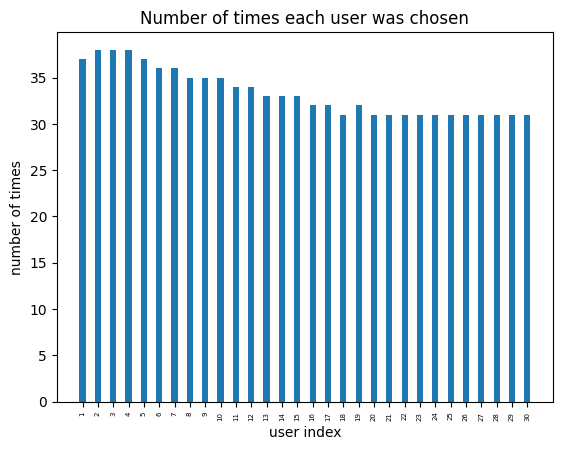

In [25]:


choices_table = np.zeros((args.global_epochs, args.num_users))
num_of_obs_arr = np.zeros((1,args.num_users))
train_loss_list = []
val_acc_list = []
val_losses_list = []
l1_norm_avg_deltha_theta_list = []
global_epochs_time_list = []


time_counter = 0
for global_epoch in tqdm(range(1, args.global_epochs+1)):
    """Part 1: Choosing Users"""
    for usr_idx in range(args.num_users):
        local_models[usr_idx].update_g(global_epoch)
        local_models[usr_idx].update_ucb(global_epoch)
    
    if args.choosing_users_verbose:
        print(f"iteration: {global_epoch}")
    a=time.time()
    rounds_choise = utils.choose_users(local_models, args, global_epoch, method=args.method_choosing_users)

    
    #choices_table[global_epoch-1, rounds_choise] = 1
    num_of_obs_arr[0,rounds_choise] += 1
    for usr_idx in rounds_choise:
        local_models[usr_idx].update_emp_avg()
        local_models[usr_idx].update_privacy_violation_and_reward()
        local_models[usr_idx].increase_num_of_obs()
        if args.choosing_users_verbose:
            print(f"user {usr_idx}, g: {local_models[usr_idx].g}, ucb: {local_models[usr_idx].ucb}, num_of_obs: {local_models[usr_idx].num_of_obs}, privacy reward: {local_models[usr_idx].privacy_reward}, curr_delay = {local_models[usr_idx].last_access_time}")
    
    max_delay = max([local_models[i].last_access_time for i in rounds_choise])
    if args.choosing_users_verbose:
        print(f"max_delay = {max_delay:.2f} seconds")
    
    
    """Part 2: Training"""
#     learning_utils.distribute_model(local_models, global_model)
#     users_avg_loss_over_local_epochs = []

#     for user_idx in rounds_choise:
#         user_loss = []
#         for local_epoch in range(args.local_epochs):
#             user = local_models[user_idx]
#             train_loss = learning_utils.train_one_epoch(user, train_criterion, args)
#             if args.lr_scheduler:
#                 user.scheduler.step(train_loss)
#             user_loss.append(train_loss)
#         users_avg_loss_over_local_epochs.append(mean(user_loss))
    
#     avg_loss_over_chosen_users_curr_global_epoch = mean(users_avg_loss_over_local_epochs)
#     train_loss_list.append(avg_loss_over_chosen_users_curr_global_epoch)


#     avg_deltha_theta = learning_utils.Fed_avg_models(local_models, global_model, rounds_choise,
#                                                       args, snr_verbose = args.snr_verbose)
#     # l1_norm_avg_deltha_theta = sum(LA.vector_norm(param.flatten(),1) for param in avg_deltha_theta.values())
#     # l1_norm_avg_deltha_theta_list.append(l1_norm_avg_deltha_theta)
#     # print(f"l1_norm_avg_deltha_theta is {l1_norm_avg_deltha_theta}")
    

#     val_acc, val_loss = learning_utils.test(test_loader, global_model, test_criterion, args)
#     val_acc_list.append(val_acc) ; val_losses_list.append(val_loss)
    

#     # boardio.add_scalars("Losses over time in seconds", {"train_loss":avg_loss_over_chosen_users_curr_global_epoch,
#     #                                     "val_loss": val_loss}, time.time()-start_time)
#     # boardio.add_scalar('Val Accuracy', val_acc, time.time()-start_time)


#     time_counter += max_delay
#     print((f"global epoch {global_epoch} has been done artifficialy in {max_delay:.2f} secs, the total time by now is {time_counter:.2f} \n with avg train loss {avg_loss_over_chosen_users_curr_global_epoch:.3f}, val loss {val_loss:.3f}, avg val acc {val_acc:.2f}%"))
#     global_epochs_time_list.append(time_counter)
#     gc.collect()


#     if val_acc > best_val_acc and args.save_best_model:
#         best_val_acc = val_acc
#         torch.save({"model's state dict":global_model.state_dict(),
#                     "train_loss_list": train_loss_list,
#                     "val_acc_list": val_acc_list,
#                     "val_losses_list": val_losses_list,
#                     "global_epochs_time_list": global_epochs_time_list,
#                     "num_of_users": args.num_users,
#                     "num_of_users_per_round": args.num_users_per_round,
#                     "l1_norm_avg_deltha_theta_list": l1_norm_avg_deltha_theta_list}
#                     , path_best_model)
    
    
#     torch.save({"model's state dict":global_model.state_dict(),
#                 "train_loss_list": train_loss_list,
#                 "val_acc_list": val_acc_list,
#                 "val_losses_list": val_losses_list,
#                 "global_epochs_time_list": global_epochs_time_list,
#                 "num_of_obs_arr": num_of_obs_arr.reshape(-1),
#                 "global_epoch": global_epoch,
#                 "num_of_users": args.num_users,
#                 "num_of_users_per_round": args.num_users_per_round,
#                 "l1_norm_avg_deltha_theta_list": l1_norm_avg_deltha_theta_list}
#                 , last_model_path)

#     if time_counter > args.max_seconds:
#         break

users_idxs = tuple([str(x) for x in range(1,args.num_users+1)])
plt.bar(users_idxs, num_of_obs_arr.reshape(-1), width = 0.4)
plt.title("Number of times each user was chosen")
plt.ylabel("number of times")
plt.xlabel("user index")
plt.xticks(rotation=90, fontsize=5)
#boardio.add_figure("Number of times each user was chosen", fig, global_epoch)
plt.savefig(last_model_path.parent / "Number of times each user was chosen.png")

#choices_table = choices_table.cumsum(axis=0)
